In [59]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
sys.path.append('src/')
from utils.methods import *

In [60]:
# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

In [61]:
# Prefix path
PREFIX_PATH = 'data'

In [62]:
# Set to display all columns
pd.set_option('display.max_columns', None)

# Set to display 50 rows
pd.set_option('display.max_rows', 50)

# Importing the final dataset
df = pd.read_csv(f'{PREFIX_PATH}/final_data_complete.csv')

In [63]:
df['Genres'] = df['Genres'].apply(str_to_list)
df['merge_year'] = df['merge_year'].astype('Int64')

In [64]:
emotion = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))
emotions_df = pd.concat([df, emotion], axis=1)

In [65]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
emotions_without_neutral = ['disgust', 'fear', 'anger', 'sadness', 'surprise', 'joy']

## Project
In this project we aim to answer the following research questions:
- What are the predominant emotional tones used in films and how do they vary across different movie genres?  
- How has the emotional tone of films evolved over time within each genre?  
- How does the emotional tone of films influence the selection of actor traits, such as age and gender?  
- Does the emotional tone of films differ between movies in different languages?  
- Can films be clustered based on their emotional tone, and do these clusters reveal distinct patterns in consumer ratings?

Let's look into them!

# What are the predominant emotional tones used in films and how do they vary across different movie genres?

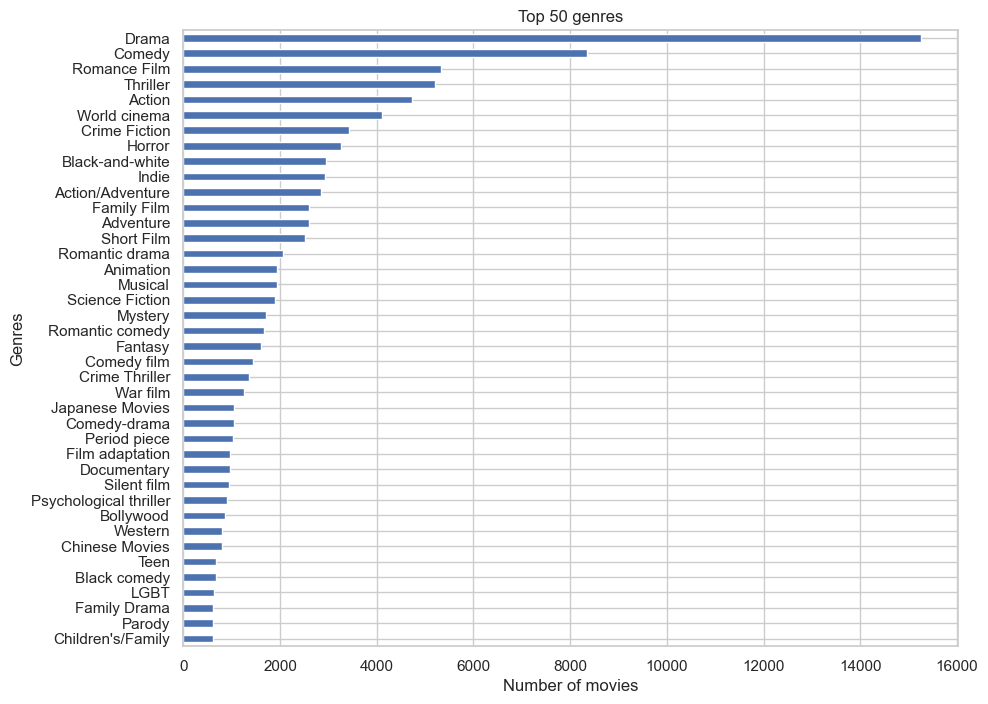

In [66]:
columns_needed = ['Plot', 'Genres', 'merge_year', 'distilbert_emotions']

# we take only the films were the plot is not missing
df_with_plot = df.dropna(subset=['Plot'])[columns_needed]

genre_count = df_with_plot['Genres'].explode().value_counts()

# plot the genre distribution first 50 genres on an orizontal bar plot
plt.figure(figsize=(10, 8))
genre_count[: 40].sort_values().plot(kind='barh')
plt.title('Top 50 genres')
plt.xlabel('Number of movies')
plt.ylabel('Genres')
plt.show()

To choose the relevant genres, we see that there is quite a natural cluster for genres that belong to more than 2000 Movies. To make analysis that have significant results, we choose only those genres that have more than 2000 movies.

In [67]:
relevant_genres = genre_count[genre_count > 2000].index
temp = df_with_plot.explode('Genres')
df_plot_genres = temp[temp['Genres'].isin(relevant_genres)].reset_index(drop=True)

In [68]:
temp = pd.DataFrame(list(df_plot_genres['distilbert_emotions'].apply(conv_to_dict))).reset_index(drop=True)

# Changes data for time series...
placeholder = pd.concat([df_plot_genres, temp], axis=1)

emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'] 

temp = placeholder.groupby('Genres').agg({
    emotion: ['mean'] for emotion in emotions
}).reset_index()
temp['count'] = placeholder['Genres'].value_counts().sort_index().values

temp.columns = ['Genres'] + emotions + ['count']
final_df = temp.set_index('Genres')
final_df

disgust      fear     anger   neutral   sadness  surprise  \
Genres                                                                         
Action            0.164581  0.157858  0.294362  0.207060  0.109015  0.039658   
Action/Adventure  0.168214  0.164287  0.300741  0.202336  0.107800  0.036135   
Adventure         0.146760  0.169830  0.226376  0.252786  0.124248  0.048896   
Black-and-white   0.188865  0.140518  0.211064  0.209114  0.169323  0.041535   
Comedy            0.159404  0.117332  0.193337  0.261184  0.155883  0.056790   
Crime Fiction     0.197055  0.170661  0.277801  0.172240  0.124140  0.035676   
Drama             0.179407  0.137836  0.197994  0.191499  0.206486  0.040810   
Family Film       0.128007  0.134138  0.191569  0.278214  0.147508  0.063800   
Horror            0.266120  0.301075  0.162985  0.140338  0.074354  0.044445   
Indie             0.187397  0.161976  0.166482  0.226826  0.180094  0.039829   
Romance Film      0.146047  0.107986  0.173731  0.214962  0.238009  0.052127   
Romantic drama    0.158726  0.111873  0.171470  0.191153  0.263211  0.045794   
Short Film        0.188522  0.143926  0.170374  0.293442  0.096887  0.057743   
Thriller          0.191495  0.230795  0.246635  0.159998  0.112830  0.043367   
World cinema      0.193272  0.131769  0.209227  0.191067  0.185803  0.044350   

                       joy  count  
Genres                             
Action            0.027467   4719  
Action/Adventure  0.020486   2841  
Adventure         0.031105   2608  
Black-and-white   0.039581   2958  
Comedy            0.056070   8348  
Crime Fiction     0.022427   3436  
Drama             0.045969  15267  
Family Film       0.056763   2608  
Horror            0.010683   3266  
Indie             0.037395   2922  
Romance Film      0.067139   5329  
Romantic drama    0.057772   2054  
Short Film        0.049106   2512  
Thriller          0.014879   5210  
World cinema      0.044512   4110

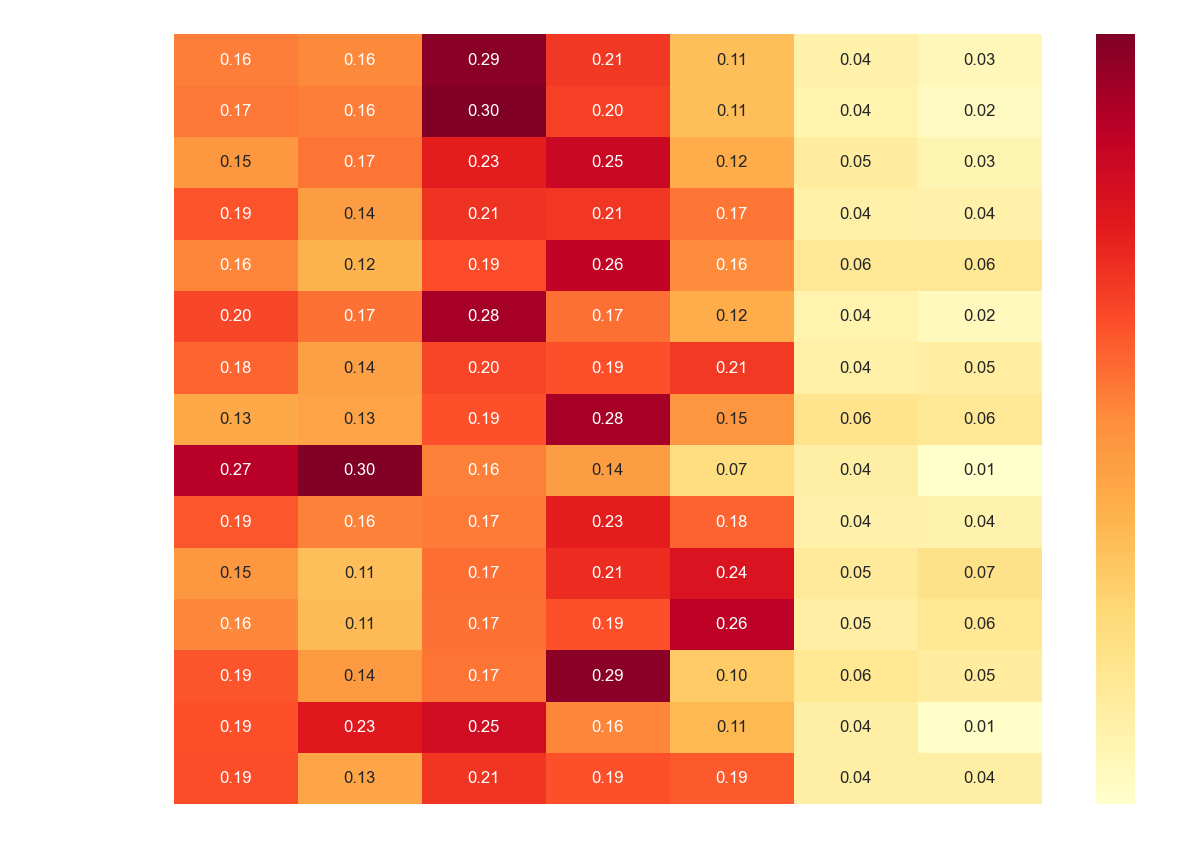

In [72]:
plt.figure(figsize=(14, 10))
ax = sns.heatmap(final_df.drop('count', axis=1), annot=True, fmt='.2f', cbar=True, cmap='YlOrRd')
plt.title('Intensity of Emotions across Genres', fontsize=16, color='white')  # Title in white
plt.ylabel('Genre', fontsize=14, color='white')  # Y-axis label in white
plt.xlabel('Emotion', fontsize=14, color='white')  # X-axis label in white

# Customize tick label colors
plt.xticks(color='white', fontsize=12)  # X-axis ticks in white
plt.yticks(color='white', fontsize=12)

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='white')  # Set the ticks color to white
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white') 

plt.gcf().patch.set_alpha(0)  # Transparent background for the figure
plt.savefig("heatmap_with_transparent_bg.png", bbox_inches='tight', transparent=True)
plt.show()

In [12]:
from statsmodels.multivariate.manova import MANOVA

In [13]:
placeholder['Genres'] = placeholder['Genres'].astype('category')

In [14]:
manova = MANOVA.from_formula(f'{ " + ".join(emotions_without_neutral) } ~ Genres', data=placeholder)
result = manova.mv_test()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Multivariate linear model
==================================================================
                                                                  
------------------------------------------------------------------
       Intercept        Value  Num DF   Den DF    F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.4863 6.0000 68168.0000 12002.9242 0.0000
         Pillai's trace 0.5137 6.0000 68168.0000 12002.9242 0.0000
 Hotelling-Lawley trace 1.0565 6.0000 68168.0000 12002.9242 0.0000
    Roy's greatest root 1.0565 6.0000 68168.0000 12002.9242 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
         Genres         Value   Num DF    Den DF   F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.8607 84.0000 379954.0376 123.4368 0.0000
         Pillai's trace 0.1458 84.0000 409038.0000 121.2627 0.0000
 Hotelling-Lawley trace 0.1545 84.0000 279139.1349 125.4173 0.0000
    Roy's greatest root 0.0851 14.0000  68173.0000 414.3267 0.0000
==================================================================

"""

We show the score in tone for each genre in comparison with the average score weighted by the number of movies in each genre.

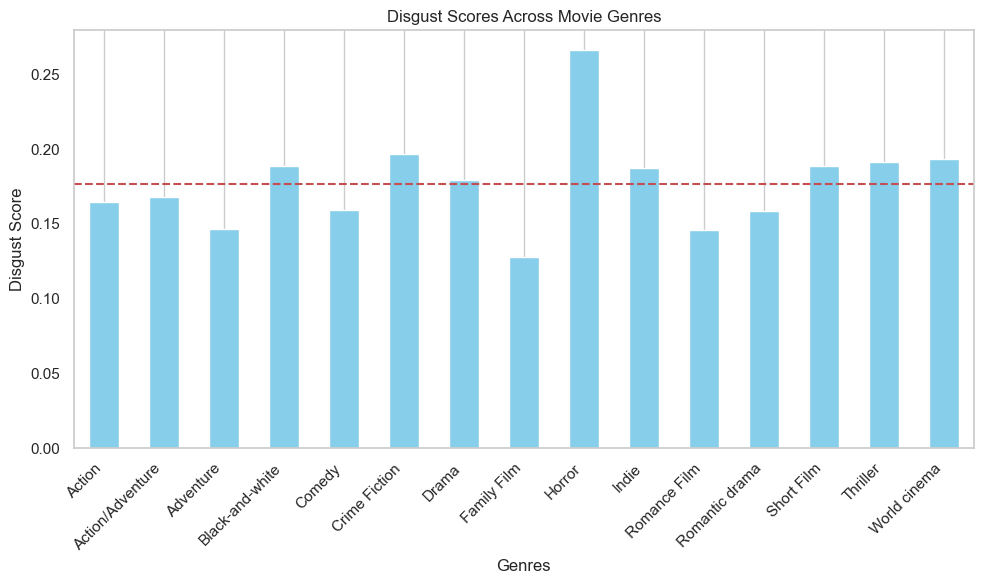

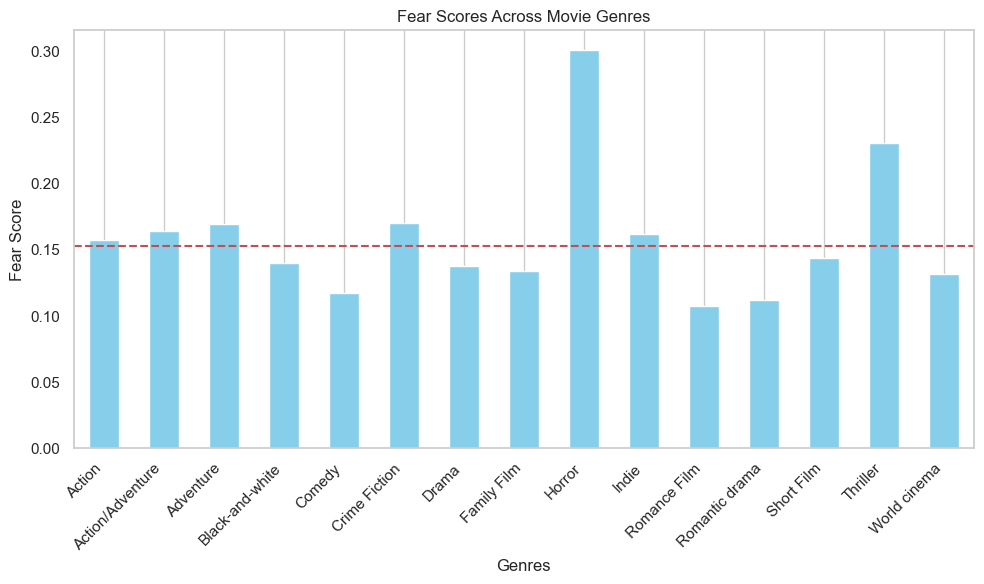

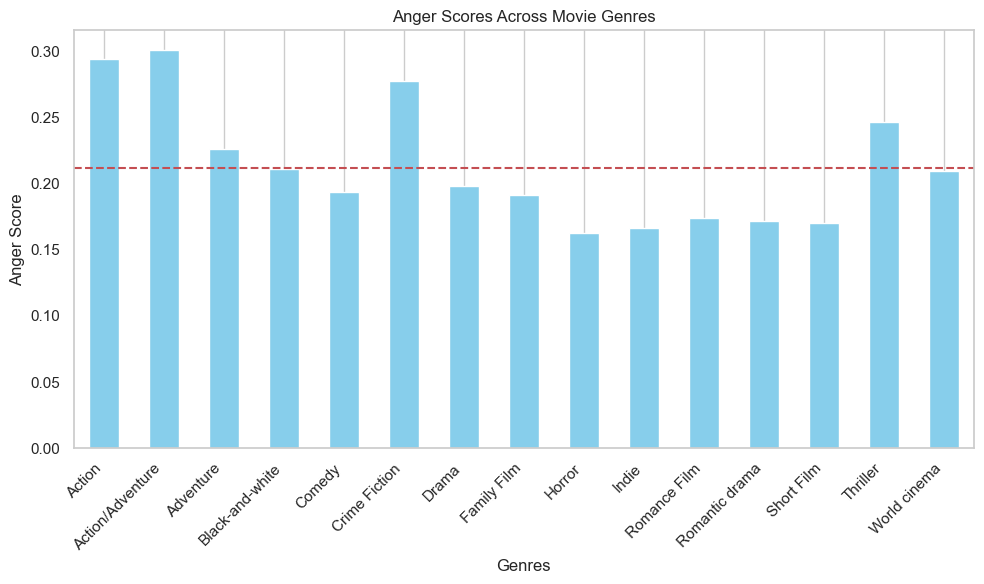

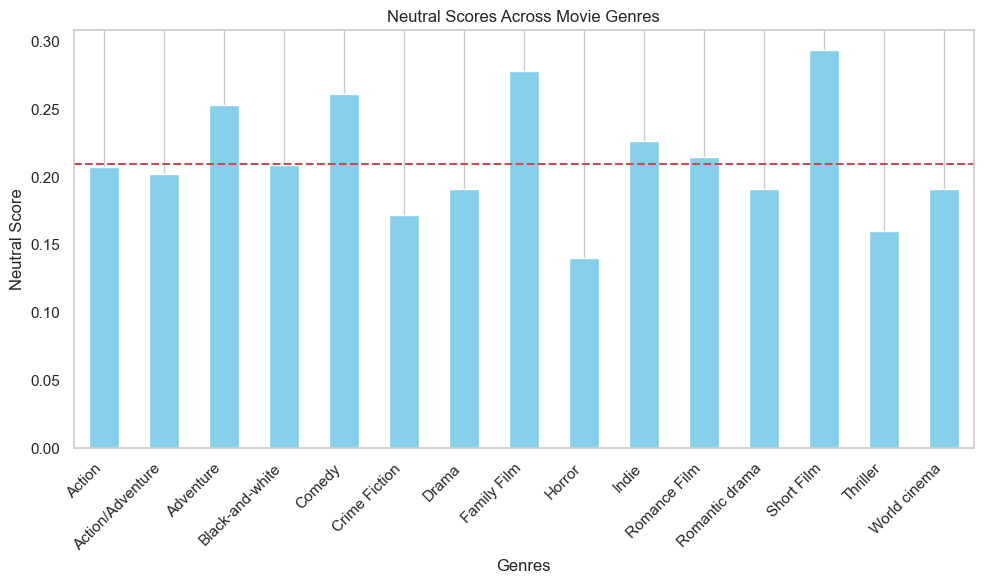

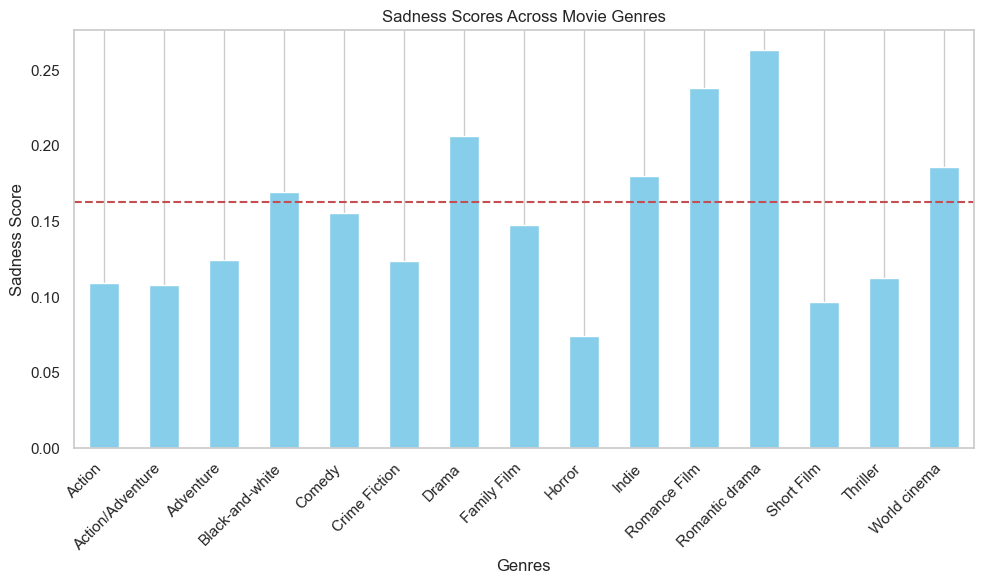

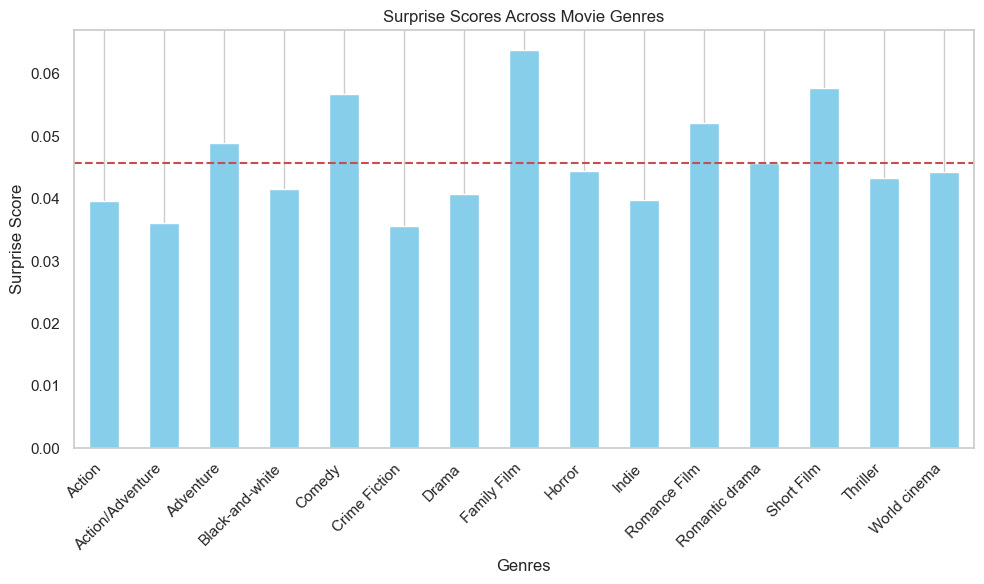

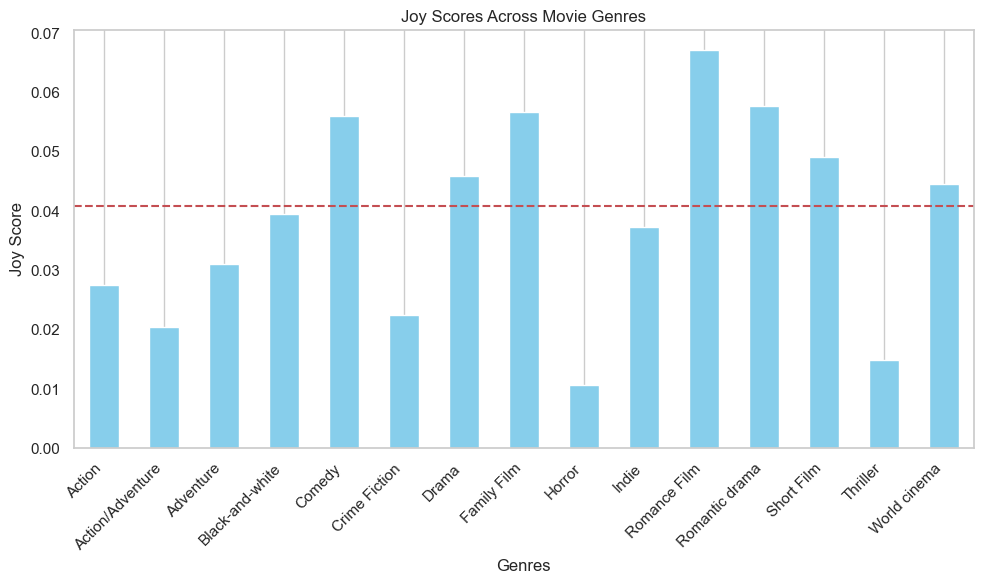

In [15]:
sum_movies = final_df['count'].sum()
weight_avg = final_df[emotions].mul(final_df['count'], axis=0).sum() / sum_movies

for emotion in emotions:
    plt.figure(figsize=(10, 6))
    final_df[emotion].plot(kind = 'bar', title = f"{emotion.capitalize()} Scores Across Movie Genres", color = 'skyblue') 
    plt.axhline(y = weight_avg[emotion], color = 'r', linestyle = '--', label = 'Average Score')
    plt.xlabel('Genres')
    plt.ylabel(f"{emotion.capitalize()} Score")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

We want to understand the predominant tones for each genre, to avoid the bias from the model predictions, we take the emotion that have a statistically significant difference from the average tone by genre using a t-test.

###############################################################
 Statistically significant emotions for Action: anger


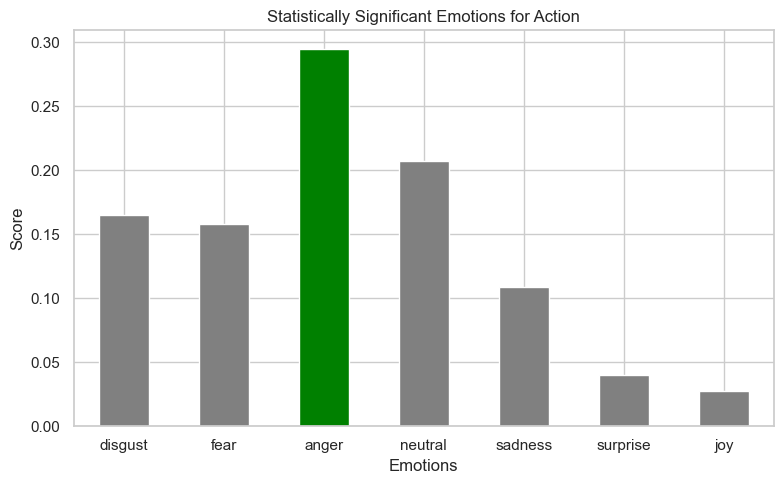

###############################################################
 Statistically significant emotions for Action/Adventure: anger


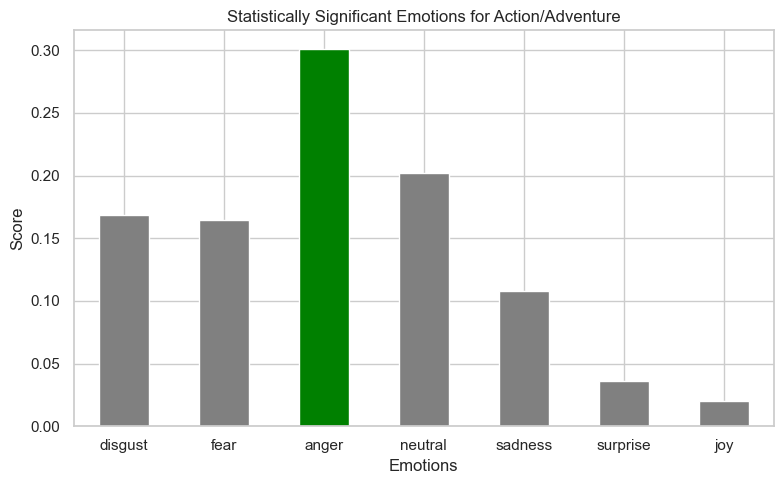

###############################################################
 Statistically significant emotions for Adventure: neutral


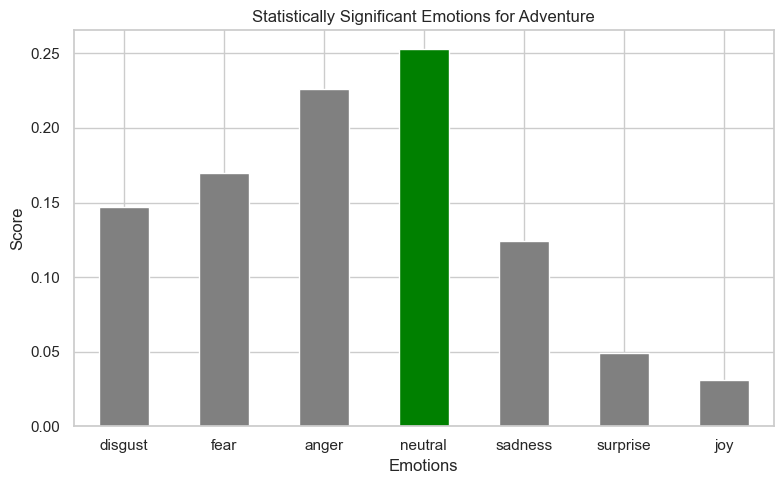

###############################################################
 Statistically significant emotions for Black-and-white: 


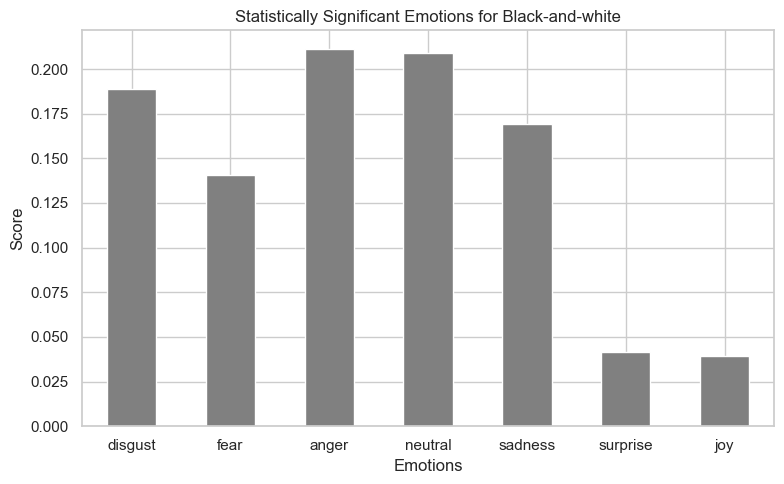

###############################################################
 Statistically significant emotions for Comedy: neutral, surprise, joy


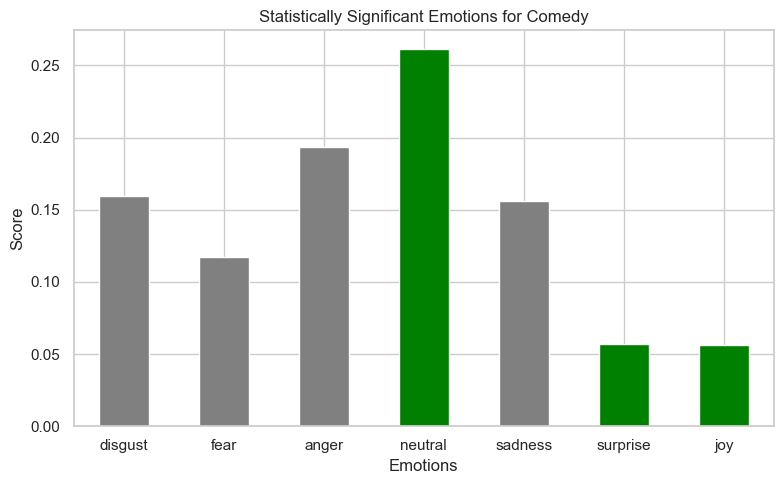

###############################################################
 Statistically significant emotions for Crime Fiction: disgust, anger


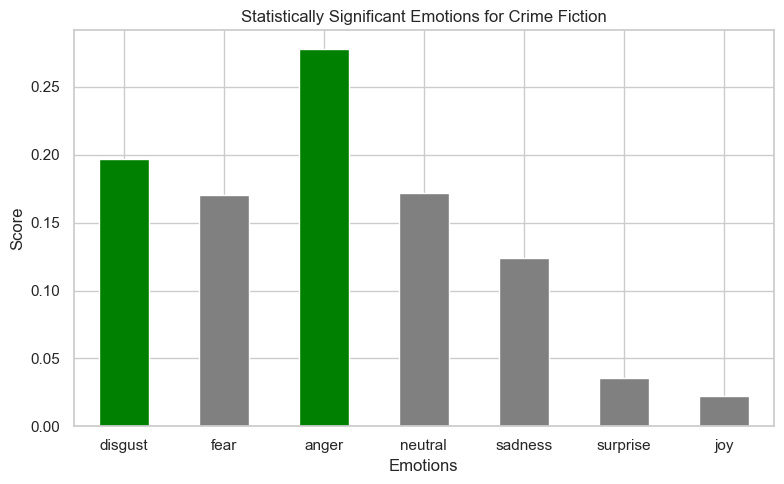

###############################################################
 Statistically significant emotions for Drama: sadness


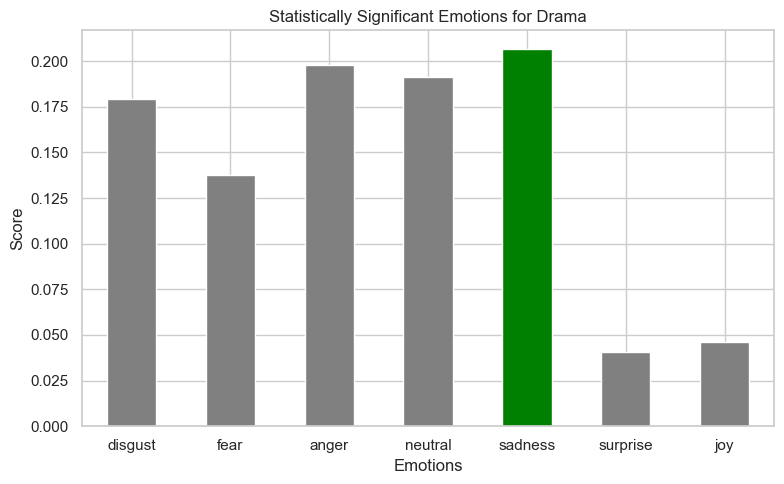

###############################################################
 Statistically significant emotions for Family Film: neutral, surprise, joy


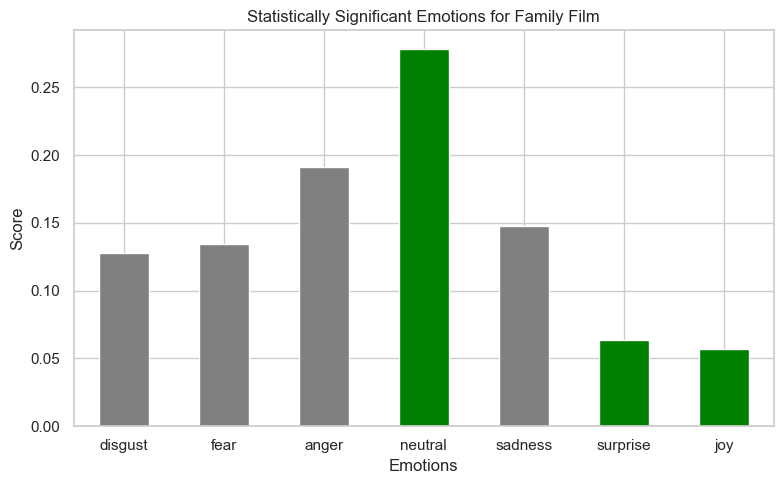

###############################################################
 Statistically significant emotions for Horror: disgust, fear


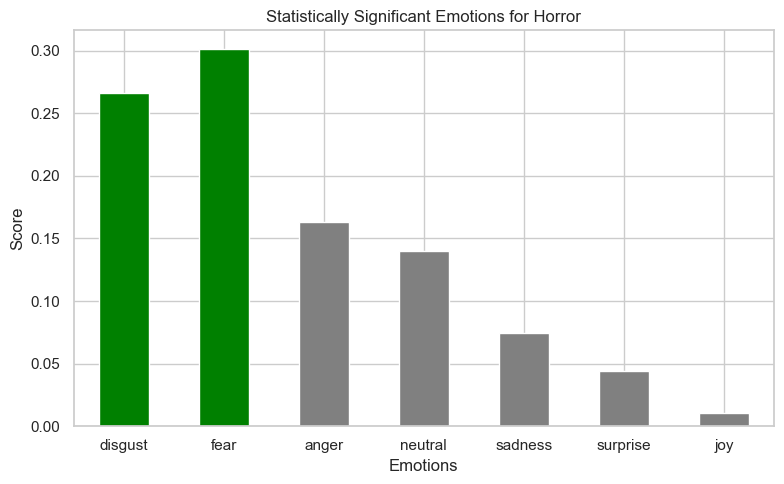

###############################################################
 Statistically significant emotions for Indie: sadness


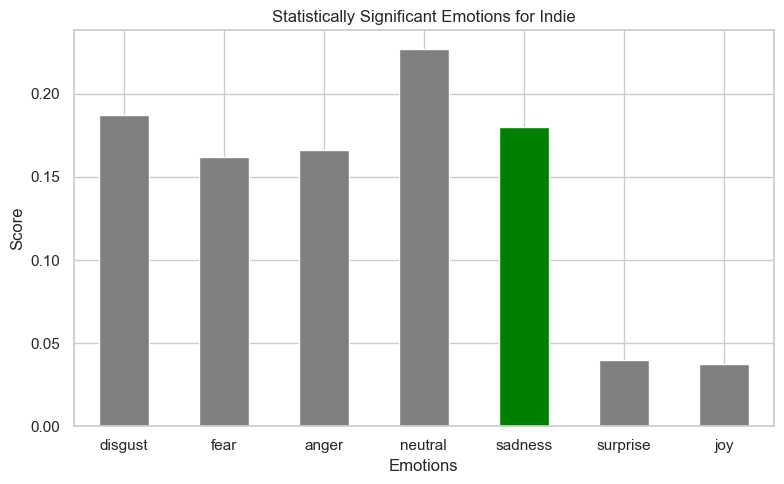

###############################################################
 Statistically significant emotions for Romance Film: sadness, surprise, joy


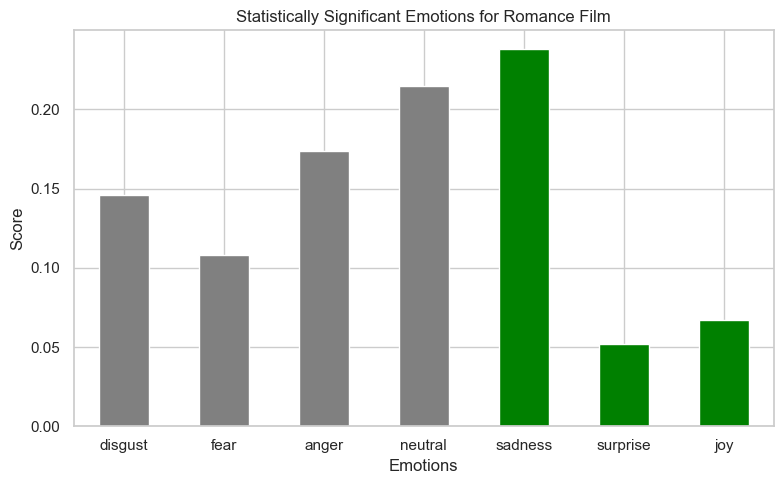

###############################################################
 Statistically significant emotions for Romantic drama: sadness, joy


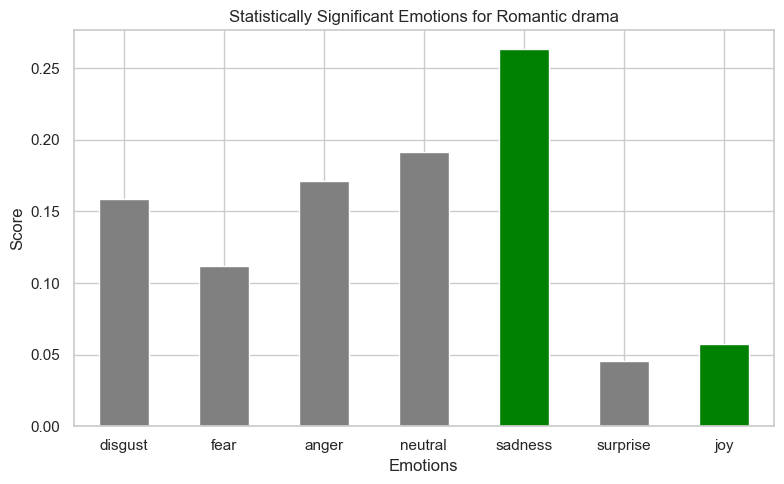

###############################################################
 Statistically significant emotions for Short Film: neutral, surprise, joy


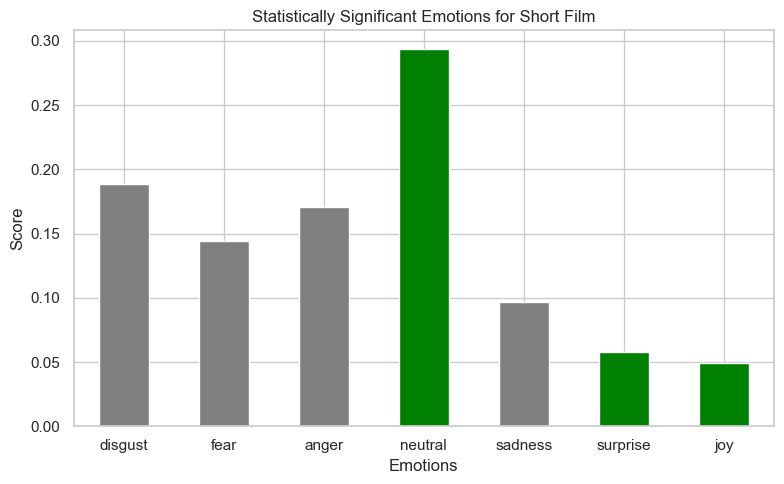

###############################################################
 Statistically significant emotions for Thriller: fear, anger


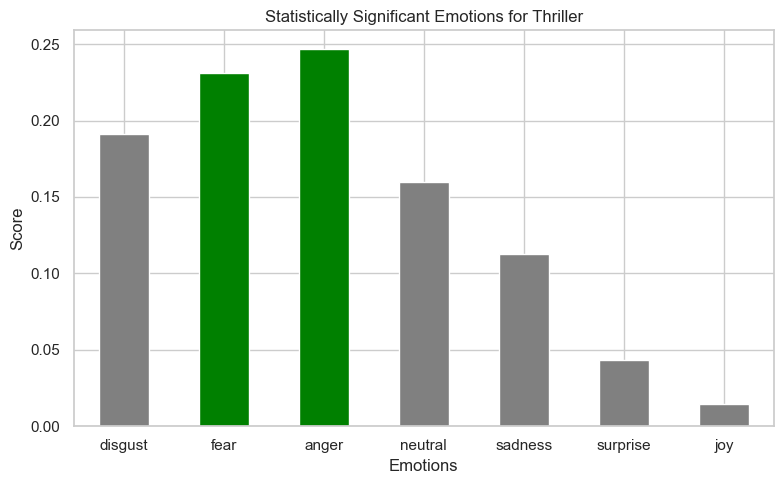

###############################################################
 Statistically significant emotions for World cinema: disgust, sadness


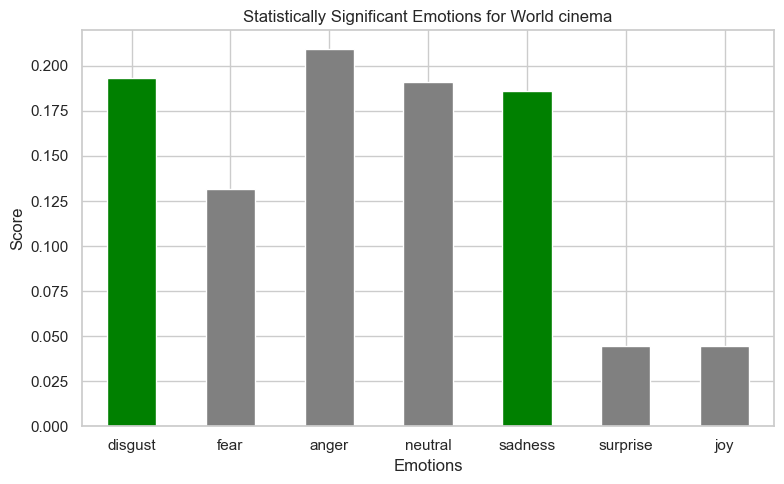

In [16]:
from scipy.stats import ttest_1samp

stat_significant_emotions = {}

for genre in final_df.index:
    genre_emotions = final_df.loc[genre, emotions]
    significant_emotions = []
    for emotion in emotions:
        # Perform a one-sample t-test
        stat, p_value = ttest_1samp(final_df[emotion], genre_emotions[emotion])
        if p_value / 2 < 0.05 and genre_emotions[emotion] > weight_avg[emotion]:
            significant_emotions.append(emotion)
    stat_significant_emotions[genre] = significant_emotions

for genre in stat_significant_emotions.keys():
    genre_emotions = final_df.loc[genre, emotions]
    significant_emotions = stat_significant_emotions[genre]
    print("###############################################################\n",
          f"Statistically significant emotions for {genre}: {', '.join(significant_emotions)}")
    plt.figure(figsize=(8, 5))
    genre_emotions.plot(kind='bar', color=['green' if emotion in significant_emotions else 'gray' for emotion in emotions])
    plt.title(f"Statistically Significant Emotions for {genre}")
    plt.xlabel("Emotions")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

After analyzing the data, here are the results for each genre:
    Action: The predominant tones is anger, that makes sense, and will we go deeper in trying to understand how the anger emotion changed over time in the time series analysis.

    Action/Adventure: The predominant tones is anger, since the genre is very similar to action, will we only keep the action genre in the time series analysis.

    Adventure: The predominant tones is neutral, al little surprising, but we do not think is interesting to analyse the evolution of a neutral emotion over time. Furthermore, Adveture is still very similar to Action, so we will not keep it in the time series analysis.

    Black-and-White: The is no predominant tone, that make sense, since it does not represent a genre, but a characteristic of the movie. We will not keep it in the time series analysis.

    Comedy: The predominant tones are neutral, surprise and joy, that makes sense, we are not interested in the neutral emotion, but we will keep the surprise and joy emotions in the time series analysis.

    Crime Fiction: The predominant tones are disgust and anger, wi will keep both in the time series analysis.

    Drama: The predominant tones is sadness, make sense, we will keep the sadness emotion in the time series analysis.

    Family Film: The predominant tones are neutral, surprise and joy, that makes sense, we are not interested in the neutral emotion, but we will keep the surprise and joy emotions in the time series analysis.

    Horror: The predominant tones are fear and disgust, we will keep both in the time series analysis.

    Indie: The predominant tones is sadness, make sense, we will keep the sadness emotion in the time series analysis.

    Romance Film: The predominant tones are sadness, joy and surprise, we keep only 2 predominant emotions, sadness and joy, in the time series analysis.

    Romantic Drama: The predominant tones are sadness and joy, since this genre is very similar to Romance Film, we will not keep it in the time series analysis.

    Short Film: The predominant tones are neutral, surprise and joy, we do not think this genre is worth analyze, like 'Black-and-White', it does not represent a genre, but a characteristic of the movie. We will not keep it in the time series analysis.

    Thriller: The predominant tones are fear and anger, we will keep both in the time series analysis.

    World cinema: This genre represent film made outside American motion picture industry, particularly those in opposition to the aesthetic and values of the Hollywood mainstream, so we keep it to have an understanding of what is the overall emotion outside the mainstream Hollywood movies. The predominant tones are sadness and disgust, we will keep both in the time series analysis.

# How has the emotional tone of films evolved over time within each genre?

In [17]:
emotion_by_time = emotions_df.groupby('merge_year').agg({
    emotion: ['mean'] for emotion in emotions
})
emotion_by_time.columns = emotions

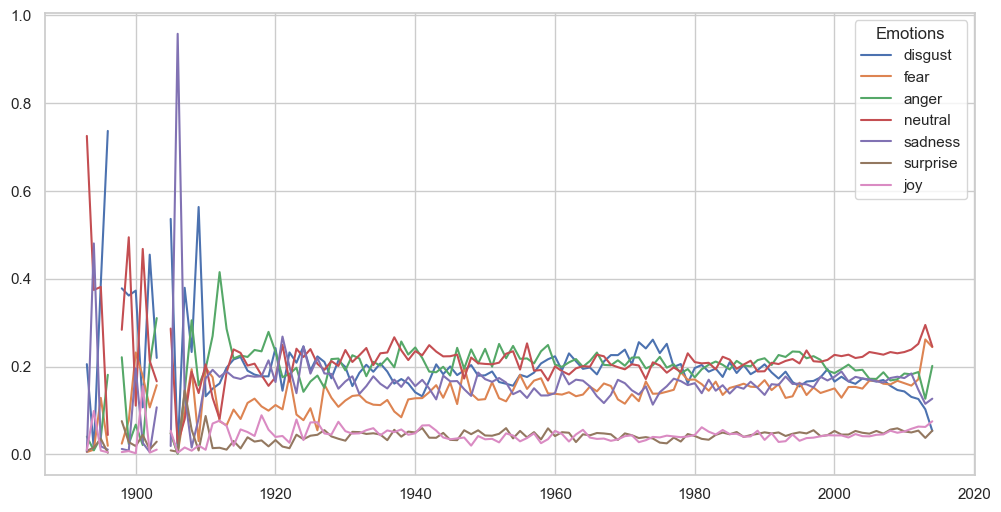

In [18]:
plt.figure(figsize=(12, 6))

for column in emotion_by_time.columns:
    plt.plot(emotion_by_time.index, emotion_by_time[column], label=column)

plt.legend(title='Emotions', loc='best')

<Axes: xlabel='merge_year', ylabel='Count'>

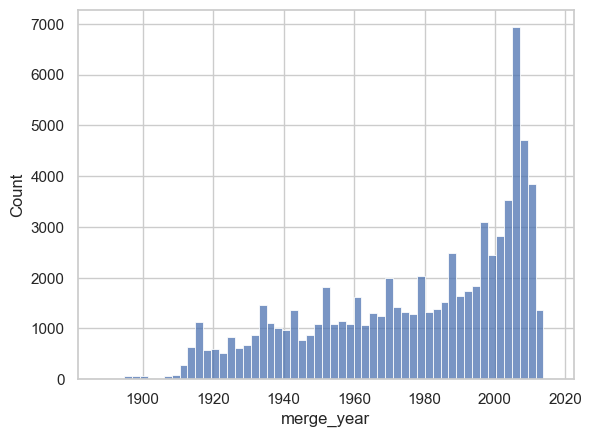

In [19]:
sns.histplot(emotions_df['merge_year'], kde=False)

In [20]:
movie_counts = emotions_df.groupby(['merge_year']).agg(
    counts=('merge_year', 'size')
)
movie_counts[movie_counts.index >= 2010]

counts
merge_year        
2010          2024
2011          1824
2012          1195
2013           164
2014            17
2015             4
2016             3

In [21]:
emotion_by_time = emotion_by_time[(emotion_by_time.index >= 1925) & (emotion_by_time.index < 2012)]

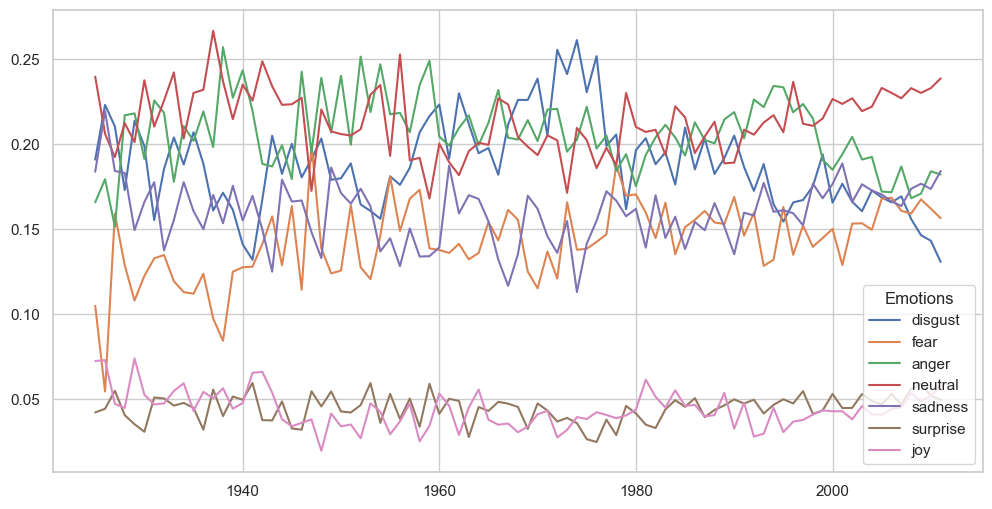

In [22]:
plt.figure(figsize=(12, 6))

for column in emotion_by_time.columns:
    plt.plot(emotion_by_time.index, emotion_by_time[column], label=column)

plt.legend(title='Emotions', loc='best')

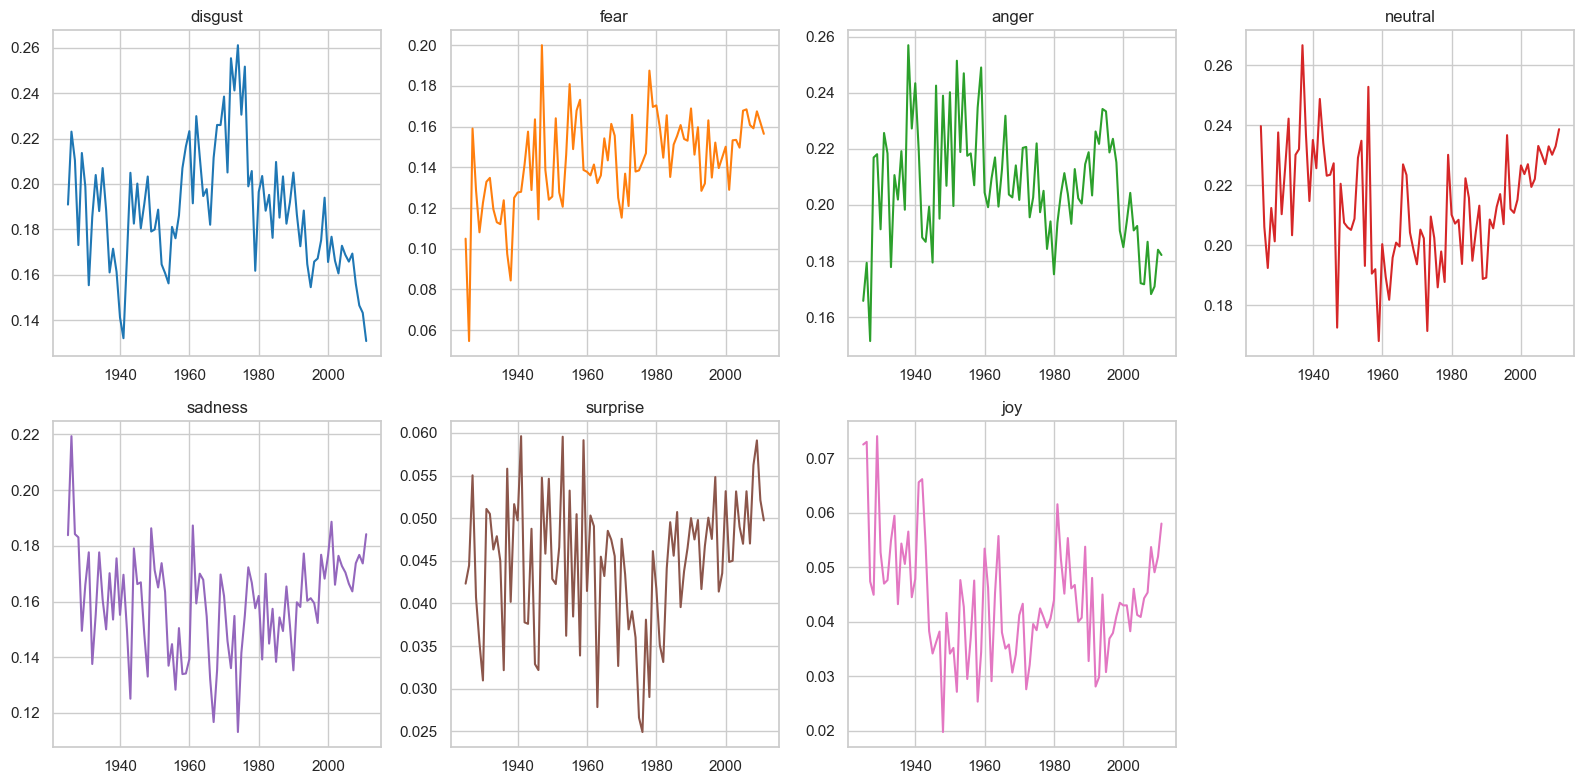

In [23]:
num_emotions = len(emotion_by_time.columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
colors = sns.color_palette("tab10", len(emotion_by_time.columns))

for ax, column, color in zip(axes, emotion_by_time.columns, colors):
    ax.plot(emotion_by_time.index, emotion_by_time[column], color=color)
    ax.set_title(column)

for ax in axes[num_emotions: ]:
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Now let's try to gain a deeper understanding and even make some predictions with time series analysis

In [24]:
columns_needed= ['Plot', 'Genres', 'merge_year', 'nrclex_emotions', 'roberta_emotions', 'distilbert_emotions']
df_tone= df.dropna(subset=['Plot'])[columns_needed]
df_tone['Genres'] = df_tone['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

relevant_genres = genre_count[genre_count>2000].index
df_ex_gen = df_tone.explode('Genres')
df_ex_relgen = df_ex_gen[df_ex_gen['Genres'].isin(relevant_genres)].reset_index(drop=True)

temp = pd.DataFrame(list(df_ex_relgen['distilbert_emotions'].apply(conv_to_dict))).reset_index(drop=True)
time_series_df = pd.concat([df_ex_relgen, temp], axis=1)

grouped_df = time_series_df.groupby(['Genres', 'merge_year'])[emotions].mean().reset_index()

genres_emotions_mapping = {
    "Action": ["anger"],
    "Comedy": ["surprise", "joy"],
    "Crime Fiction": ["disgust", "anger"],
    "Drama": ["sadness"],
    "Family Film": ["surprise", "joy"],
    "Horror": ["fear", "disgust"],
    "Indie": ["sadness"],
    "Romance Film": ["sadness", "joy"],
    "Thriller": ["fear", "anger"],
    "World cinema": ["sadness", "disgust"]
}

filtered_df = grouped_df[(grouped_df["Genres"].isin(genres_emotions_mapping.keys())) &
                        ((grouped_df["merge_year"] >= 1925) & (grouped_df["merge_year"] < 2012))]
filtered_df[filtered_df['Genres'] == 'World cinema']

Genres  merge_year   disgust      fear     anger   neutral  \
1423  World cinema        1927  0.058494  0.361429  0.454733  0.083778   
1424  World cinema        1928  0.155387  0.282051  0.448896  0.067146   
1425  World cinema        1929  0.450881  0.018192  0.059123  0.103908   
1426  World cinema        1930  0.228029  0.110362  0.269671  0.100799   
1427  World cinema        1931  0.090704  0.022110  0.343663  0.218374   
...            ...         ...       ...       ...       ...       ...   
1501  World cinema        2007  0.170133  0.158563  0.181986  0.208199   
1502  World cinema        2008  0.159076  0.122740  0.179165  0.231670   
1503  World cinema        2009  0.147819  0.161387  0.180398  0.219040   
1504  World cinema        2010  0.179574  0.146968  0.187775  0.219774   
1505  World cinema        2011  0.144722  0.102013  0.223741  0.210499   

       sadness  surprise       joy  
1423  0.027268  0.011397  0.002901  
1424  0.039003  0.002362  0.005156  
1425  0.298626  0.055974  0.013297  
1426  0.276180  0.010927  0.004030  
1427  0.144336  0.089297  0.091517  
...        ...       ...       ...  
1501  0.181751  0.056520  0.042847  
1502  0.196654  0.045741  0.064955  
1503  0.193846  0.058199  0.039312  
1504  0.152972  0.048458  0.064478  
1505  0.195826  0.064587  0.058612  

[83 rows x 9 columns]

In [25]:
# Dividing the data into separate dataframes to separate the time series analysis 
genre_dataframes = {}

for genre, emotions in genres_emotions_mapping.items():
    genre_data = filtered_df[filtered_df["Genres"] == genre]
    genre_dataframes[genre] = genre_data[["merge_year"] + emotions].dropna()

action_df = genre_dataframes["Action"]
comedy_df = genre_dataframes["Comedy"]
crime_fiction_df = genre_dataframes["Crime Fiction"]
drama_df = genre_dataframes["Drama"]
family_film_df = genre_dataframes["Family Film"]
horror_df = genre_dataframes["Horror"]
indie_df = genre_dataframes["Indie"]
romance_film_df = genre_dataframes["Romance Film"]
thriller_df = genre_dataframes["Thriller"]
world_cinema_df = genre_dataframes["World cinema"]

#### Action movies Time Series Analysis

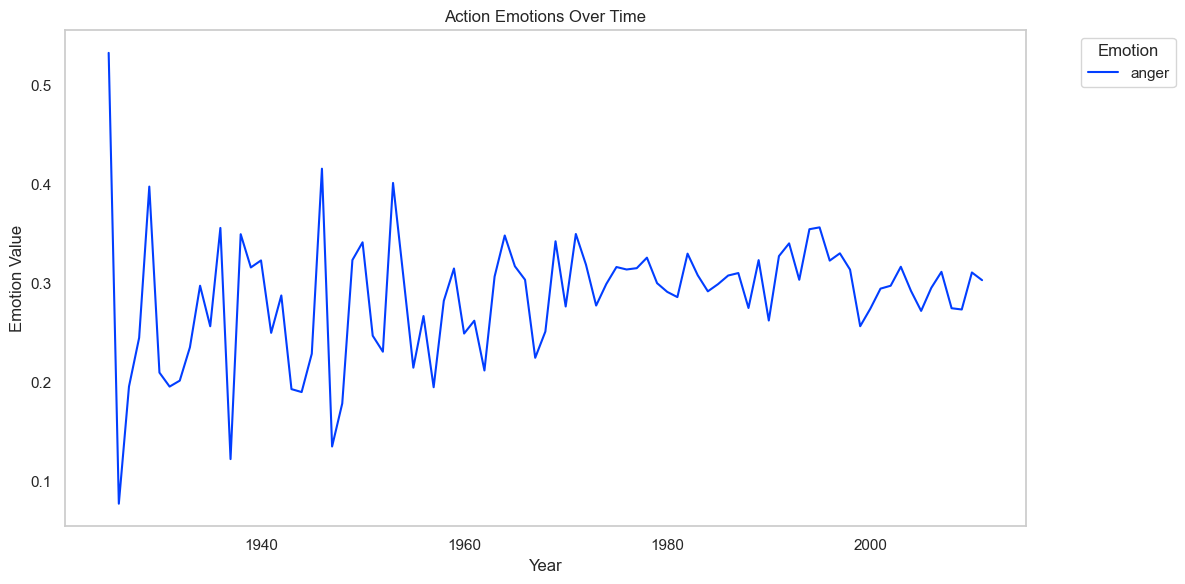

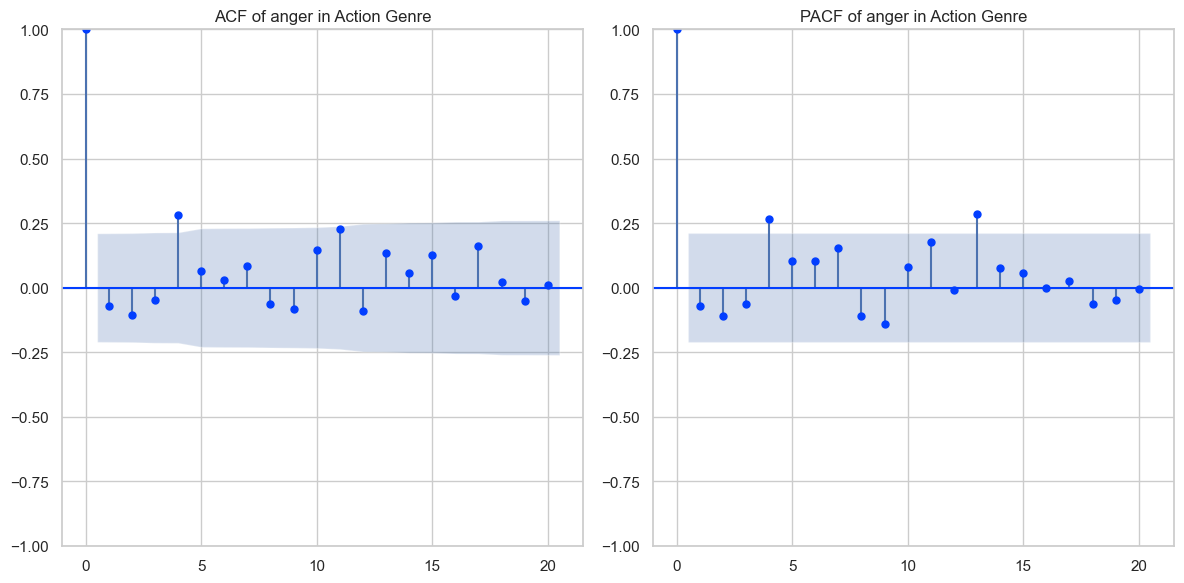

##########################################
 Performing Box-Jenkins Procedure for anger in Action Genre
ADF Statistic: -1.7887471533083892
p-value: 0.3860625573236628
The series is not stationary and needs to be differenced.
Best ARIMA Order for anger in Action Genre: (3, 1, 1)


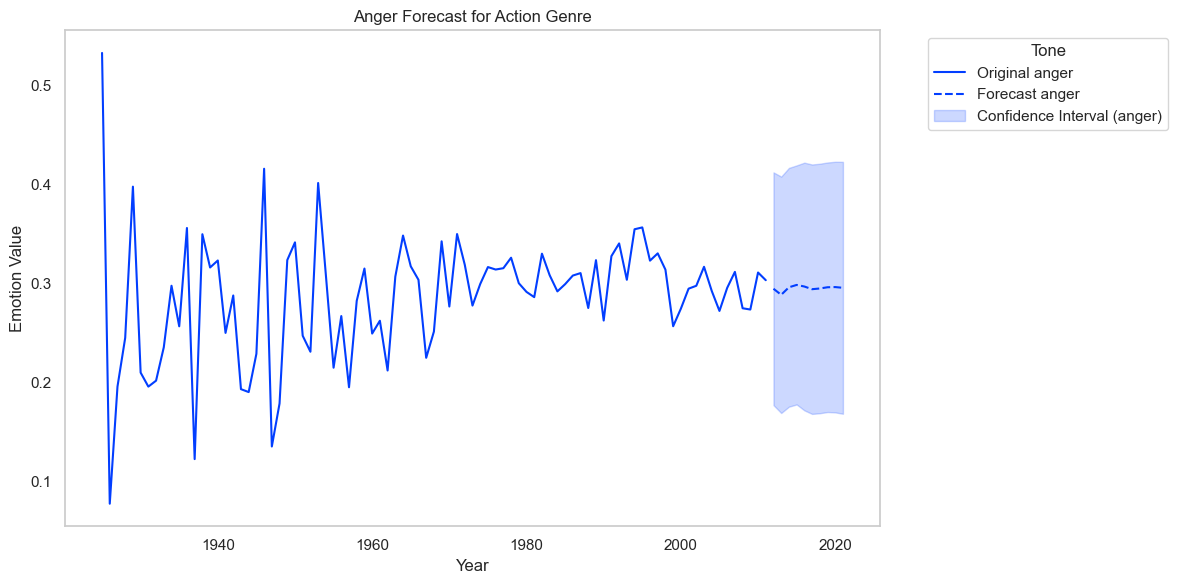

In [26]:
timeseries_plots(action_df, "Action")
action_ts_results = box_jenkins_procedure(action_df, "Action")
action_forecast_df = forecast_series(action_df, "Action", action_ts_results)

#### Comedy movies Time Series Analysis

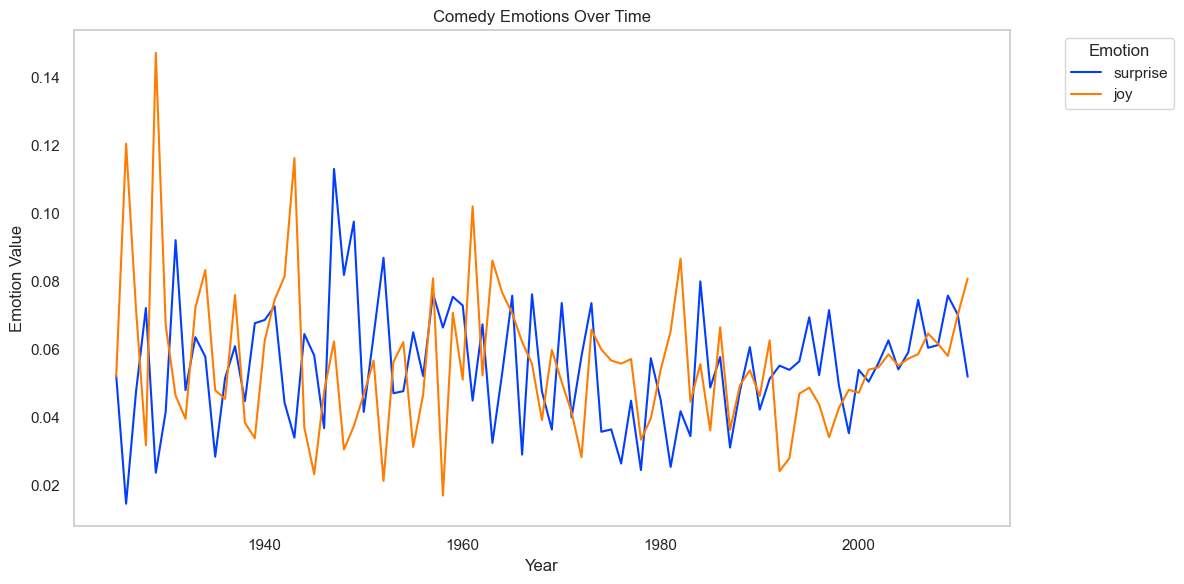

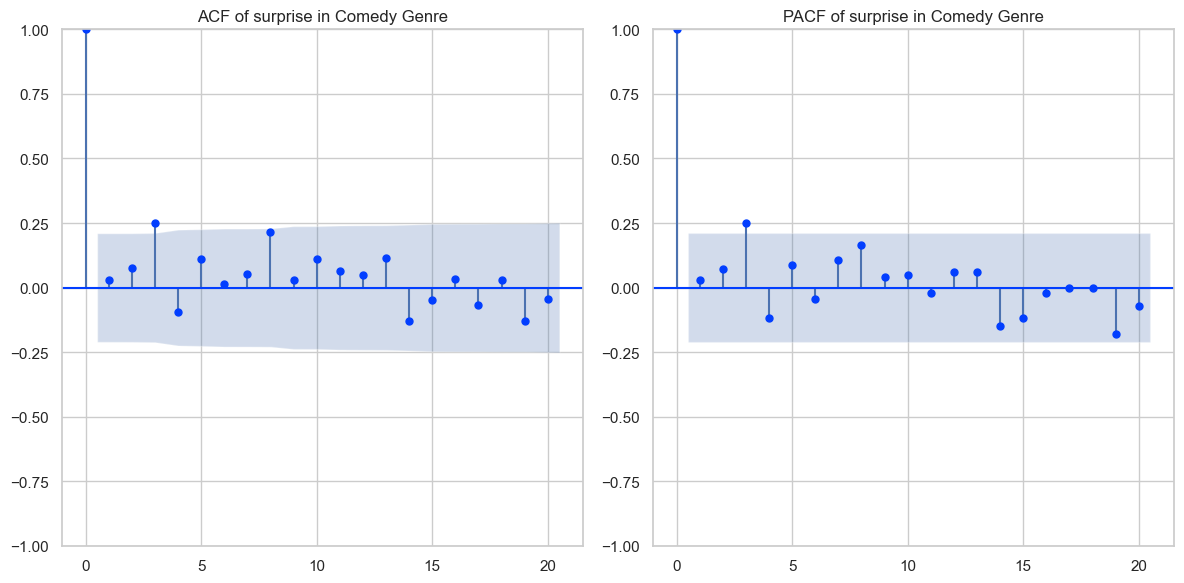

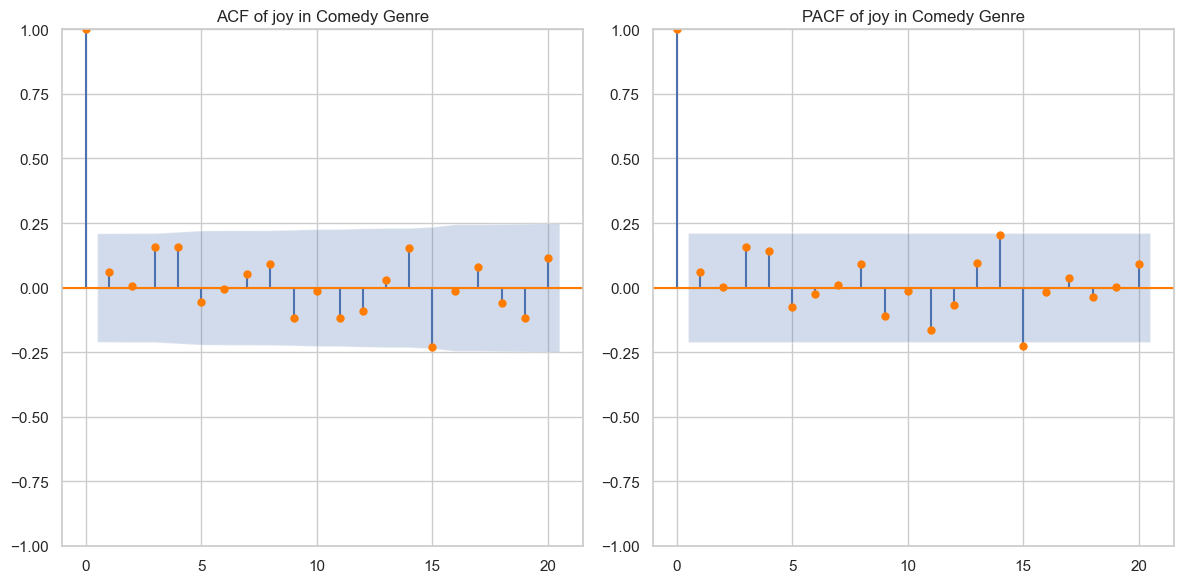

##########################################
 Performing Box-Jenkins Procedure for surprise in Comedy Genre
ADF Statistic: -3.885543579621154
p-value: 0.0021438522199676516
Best ARIMA Order for surprise in Comedy Genre: (3, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Comedy Genre
ADF Statistic: -8.5479135141675
p-value: 9.393303846546055e-14
Best ARIMA Order for joy in Comedy Genre: (1, 0, 0)


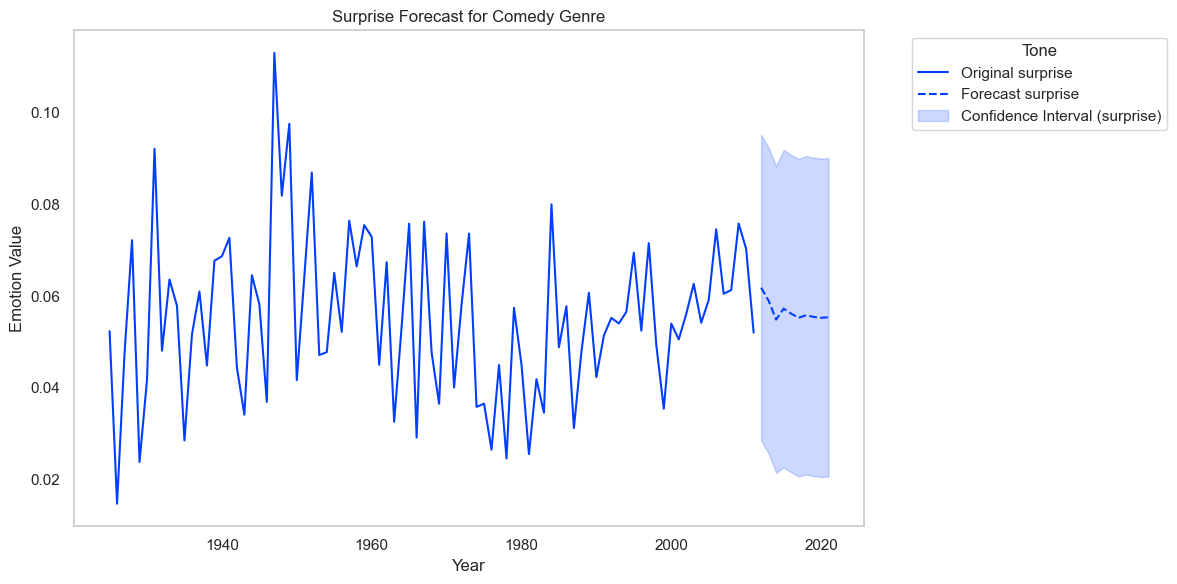

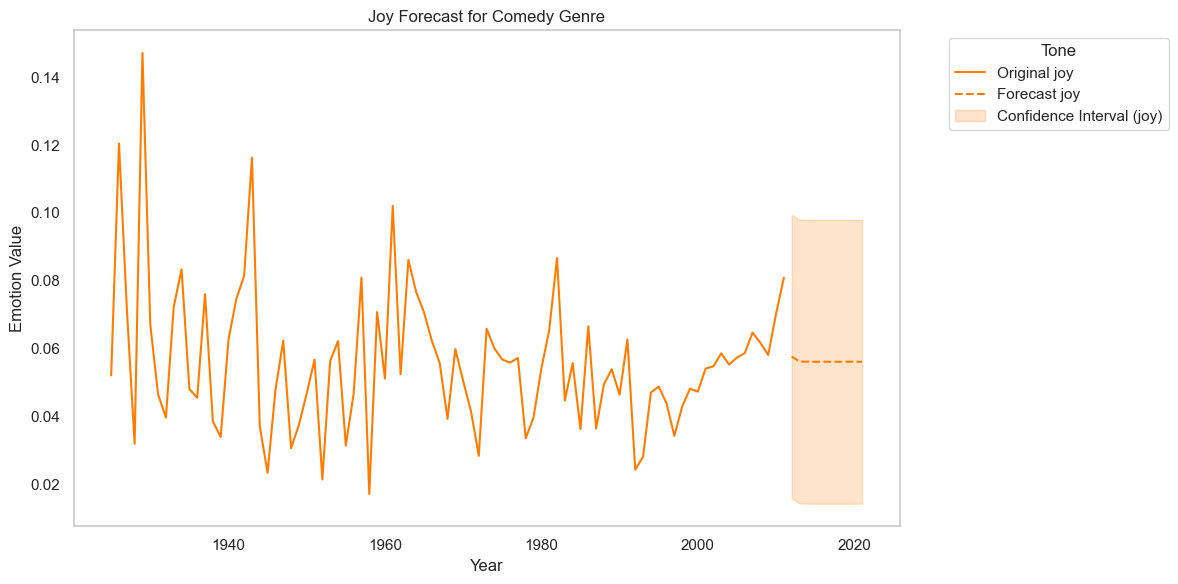

In [27]:
timeseries_plots(comedy_df, "Comedy")
comedy_ts_results = box_jenkins_procedure(comedy_df, "Comedy")
comedy_forecast_df = forecast_series(comedy_df, "Comedy", comedy_ts_results)

#### Crime Fiction movies Time Series Analysis

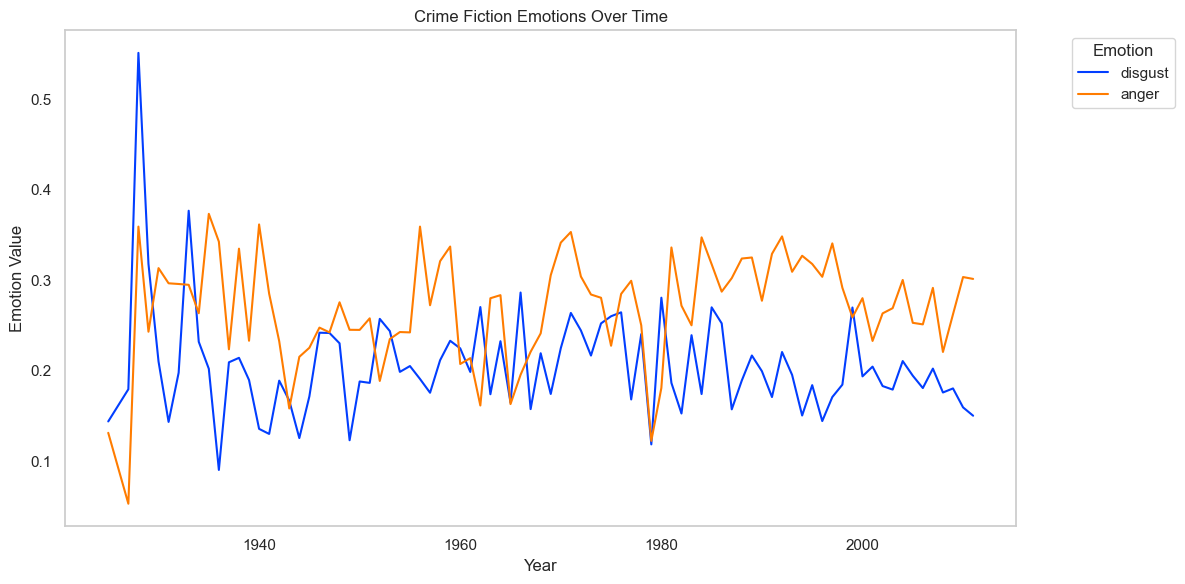

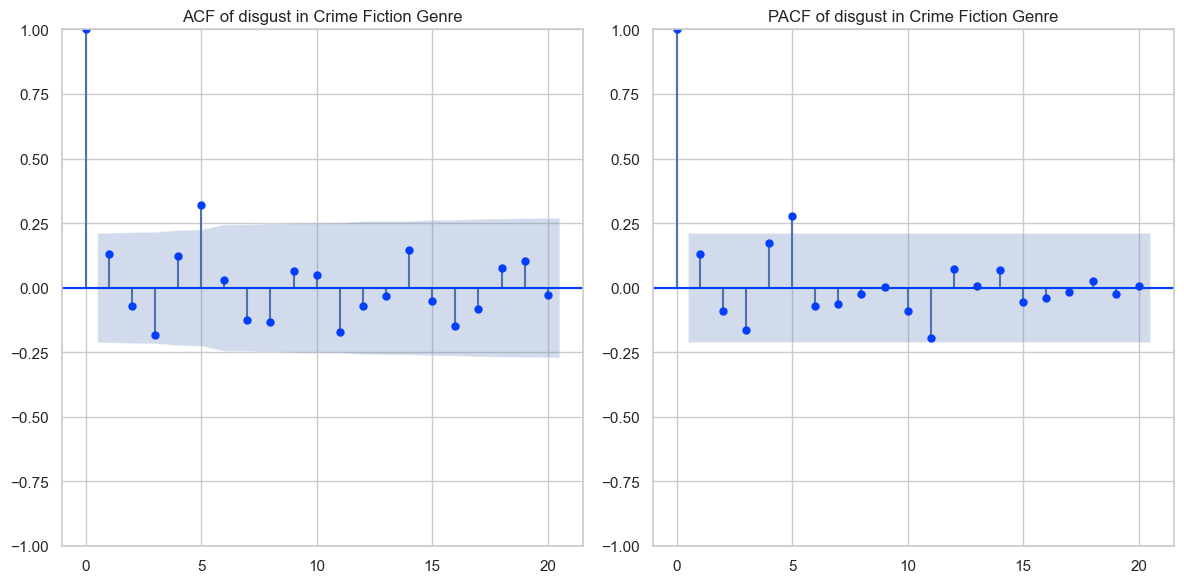

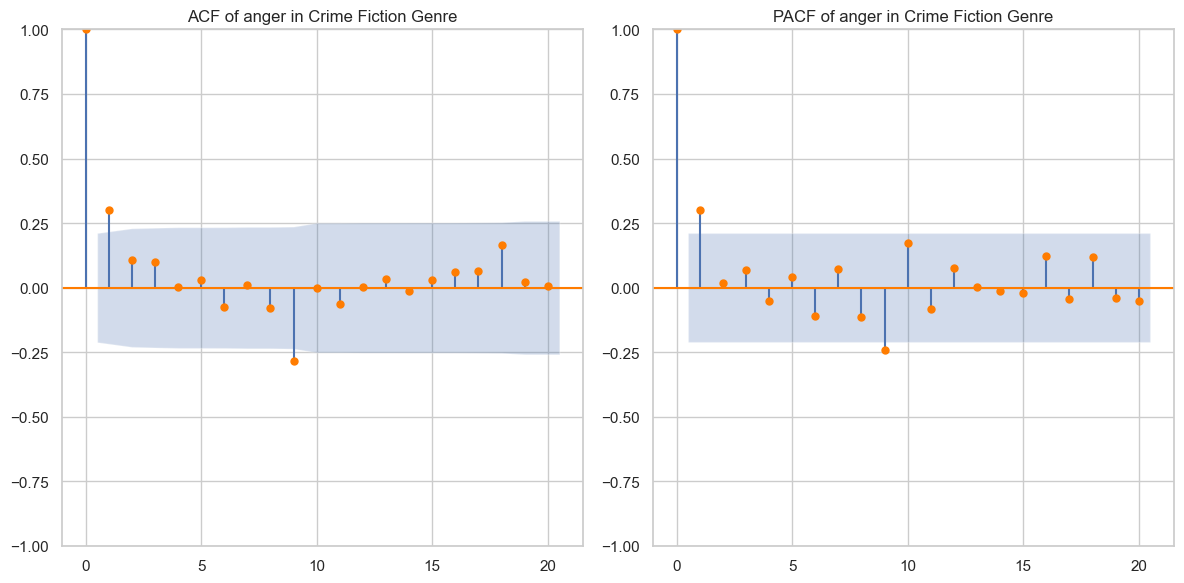

##########################################
 Performing Box-Jenkins Procedure for disgust in Crime Fiction Genre
ADF Statistic: -6.484593942005353
p-value: 1.2701419125844921e-08
Best ARIMA Order for disgust in Crime Fiction Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Crime Fiction Genre
ADF Statistic: -6.914634533444469
p-value: 1.1881064710608045e-09
Best ARIMA Order for anger in Crime Fiction Genre: (1, 0, 0)


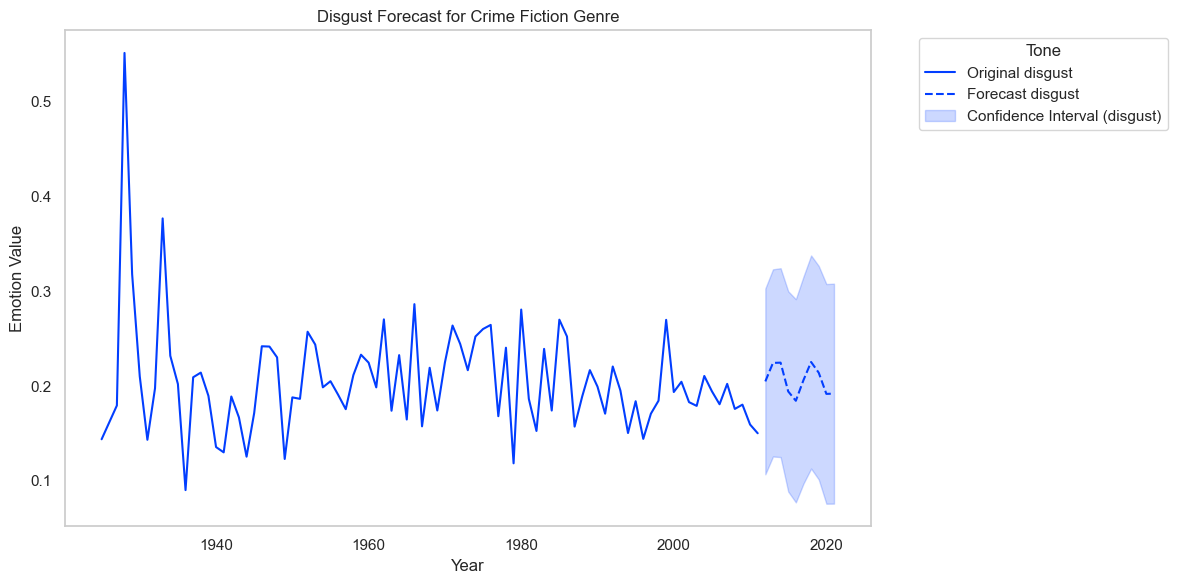

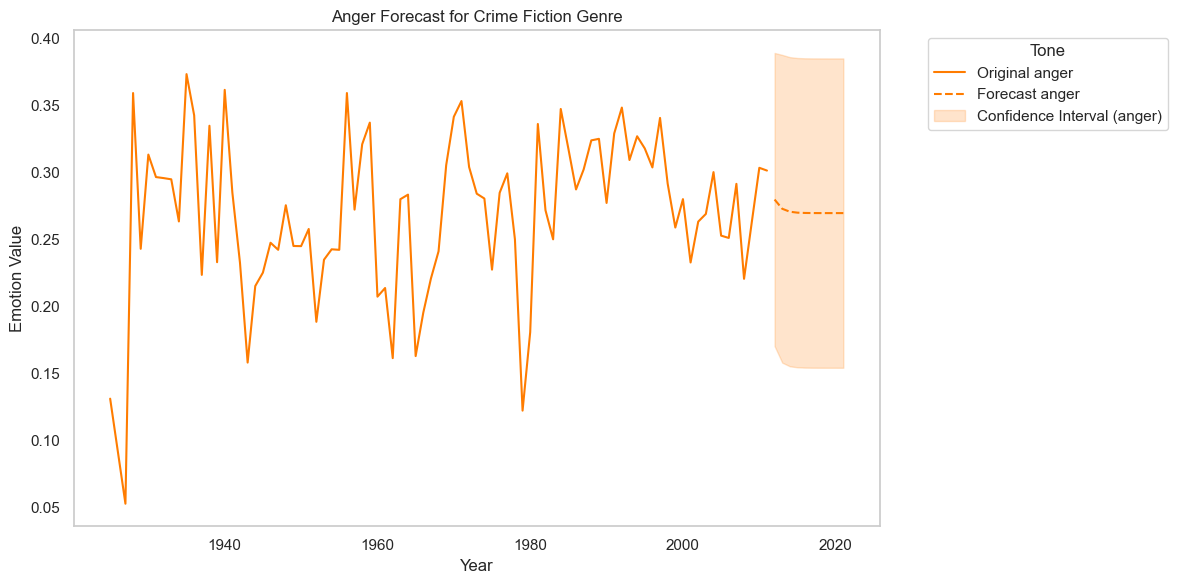

In [28]:
timeseries_plots(crime_fiction_df, "Crime Fiction")
crime_fiction_ts_results = box_jenkins_procedure(crime_fiction_df, "Crime Fiction")
crime_fiction_forecast_df = forecast_series(crime_fiction_df, "Crime Fiction", crime_fiction_ts_results)

#### Drama movies Times Series Analysis

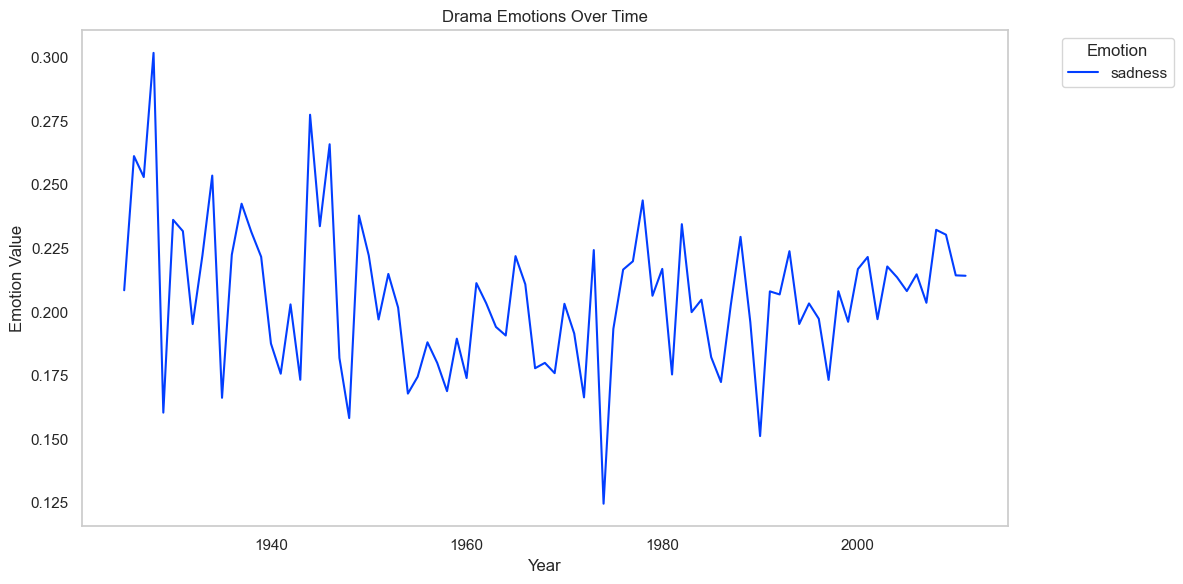

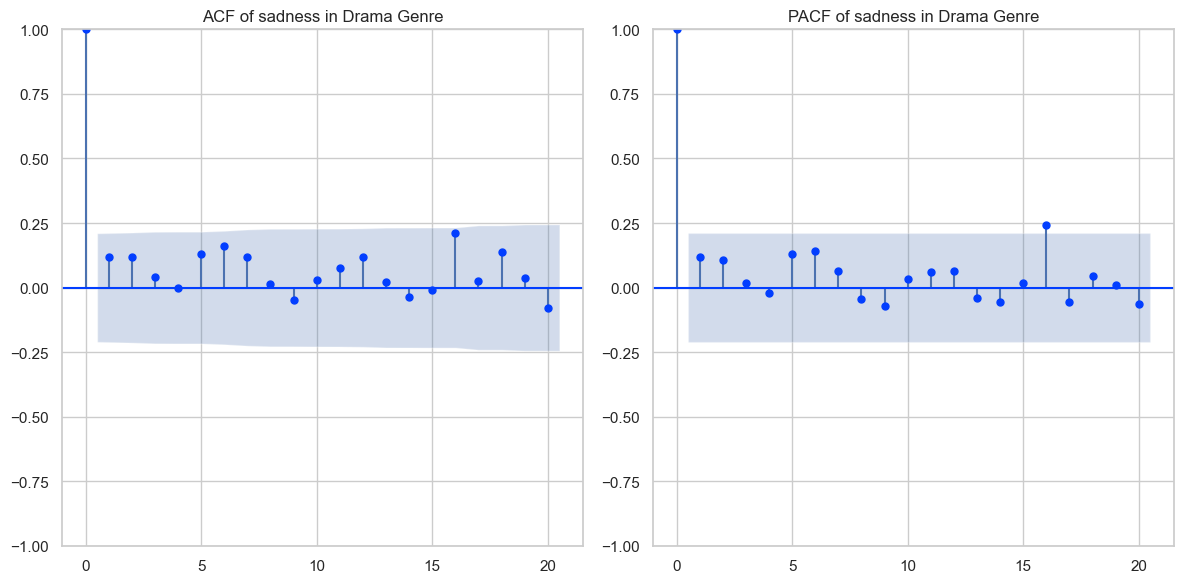

##########################################
 Performing Box-Jenkins Procedure for sadness in Drama Genre
ADF Statistic: -8.131424158962504
p-value: 1.0876387226298501e-12
Best ARIMA Order for sadness in Drama Genre: (1, 0, 1)


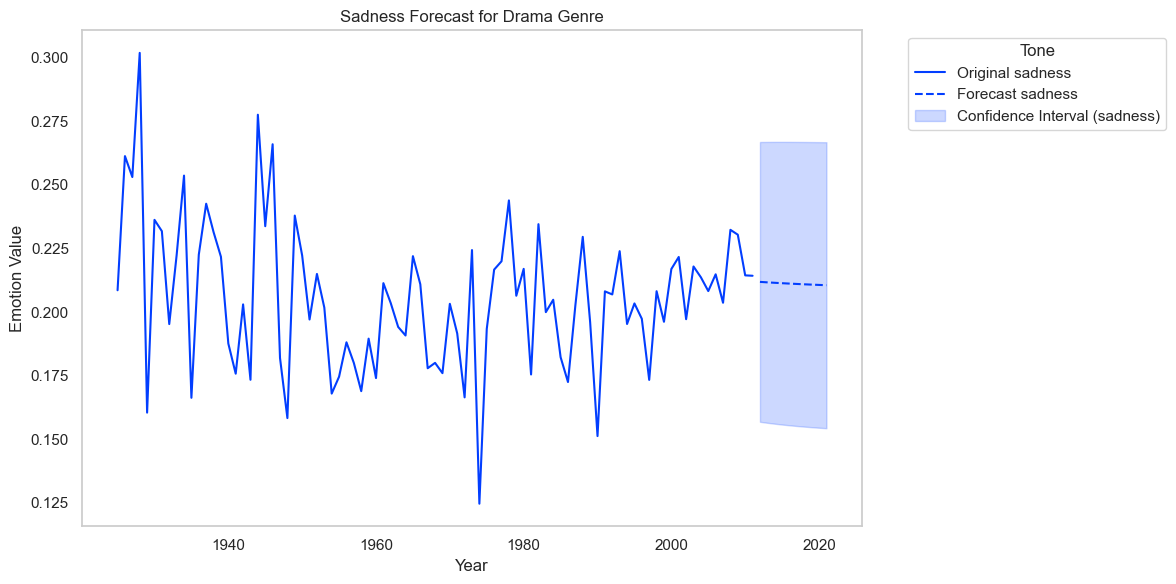

In [29]:
timeseries_plots(drama_df, "Drama")
drama_ts_results = box_jenkins_procedure(drama_df, "Drama")
drama_forecast_df = forecast_series(drama_df, "Drama", drama_ts_results)

#### Family Film movies Time Series Analysis

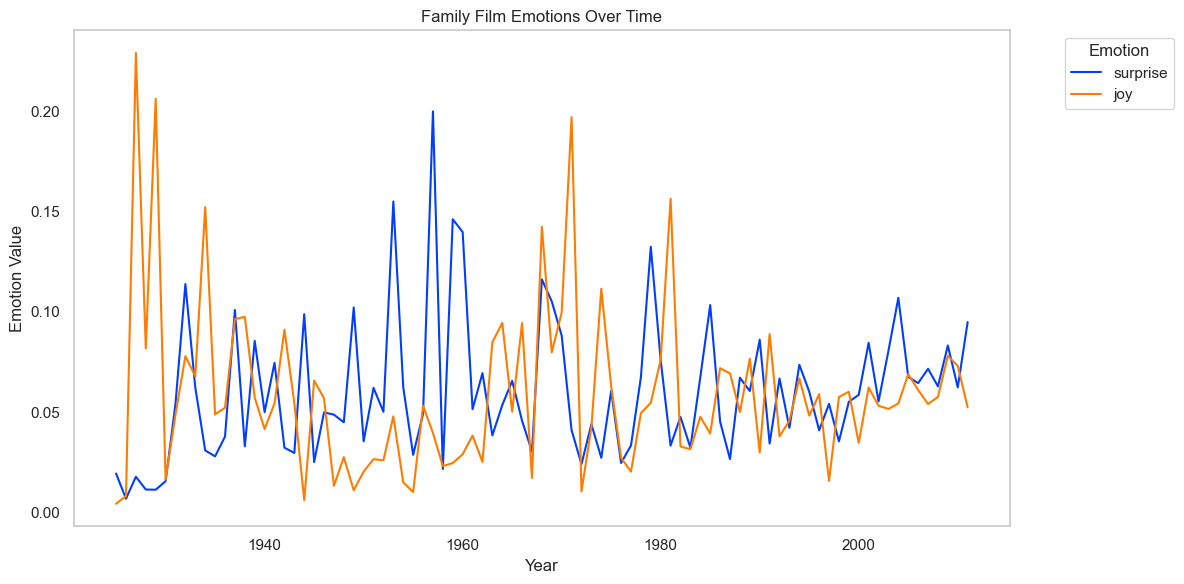

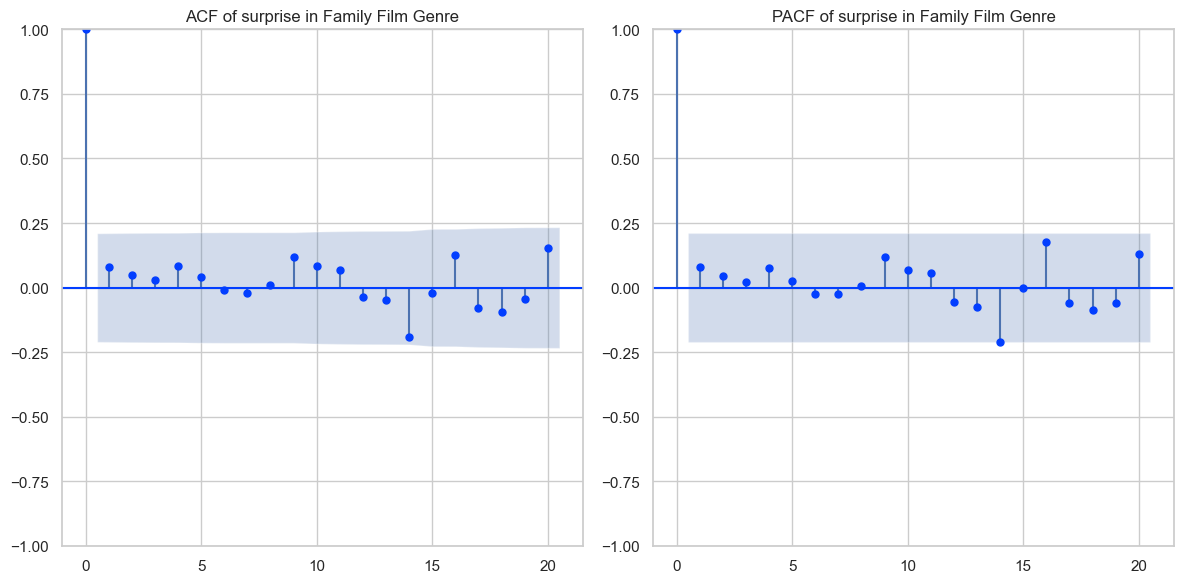

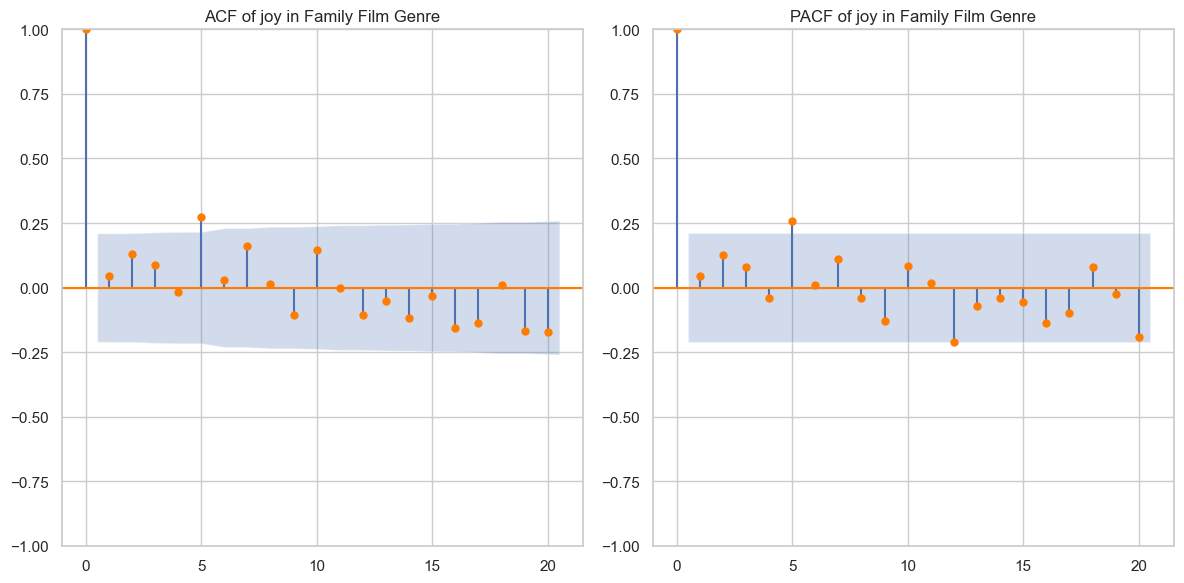

##########################################
 Performing Box-Jenkins Procedure for surprise in Family Film Genre
ADF Statistic: -8.473655078539824
p-value: 1.4548682542497525e-13
Best ARIMA Order for surprise in Family Film Genre: (1, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Family Film Genre
ADF Statistic: -4.269389640840538
p-value: 0.0005016691687662518
Best ARIMA Order for joy in Family Film Genre: (3, 0, 1)


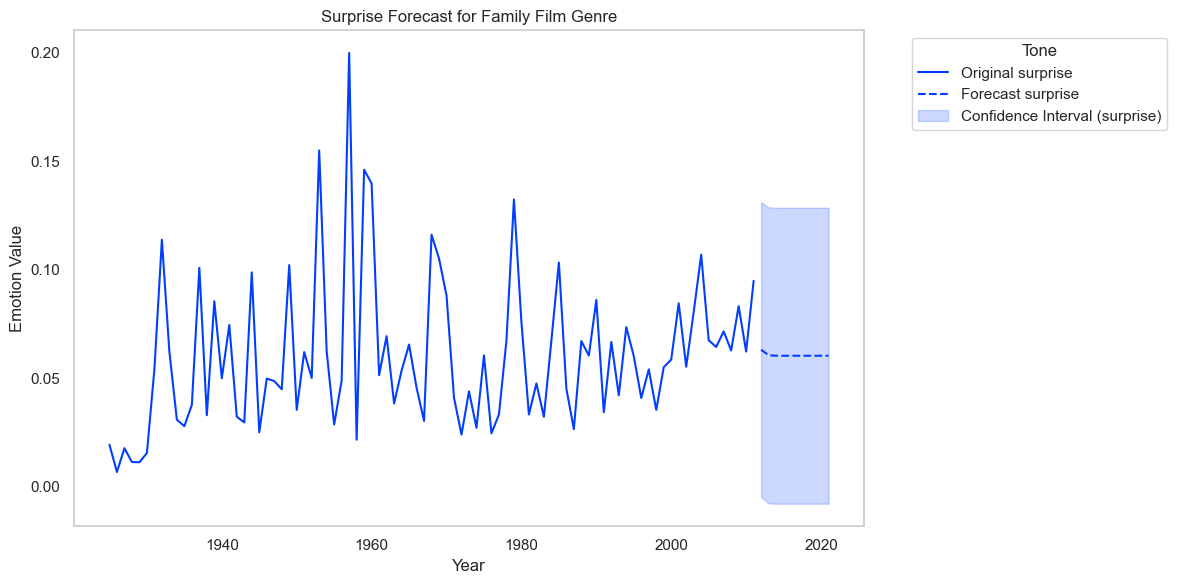

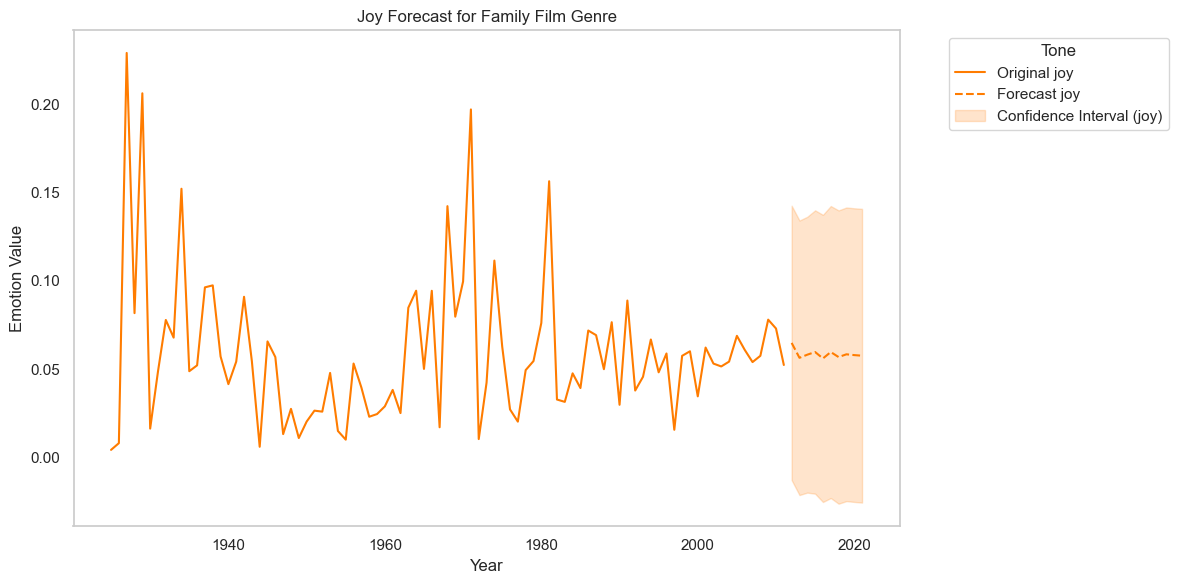

In [30]:
timeseries_plots(family_film_df, "Family Film")
family_ts_results = box_jenkins_procedure(family_film_df, "Family Film")
family_forecast_df = forecast_series(family_film_df, "Family Film", family_ts_results)

#### Horror movies Times Series Analysis

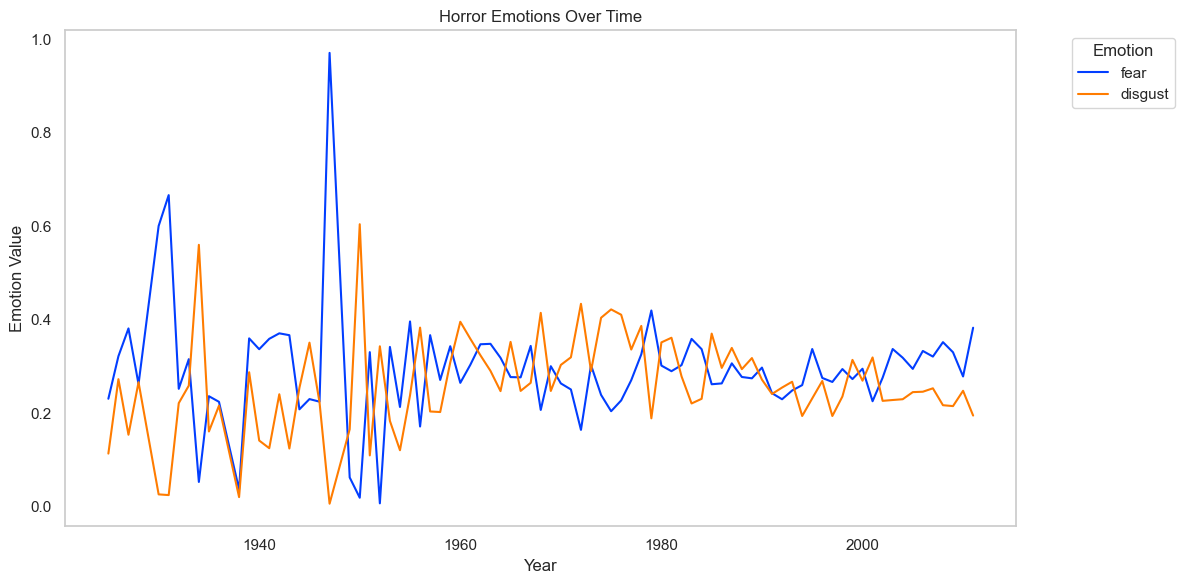

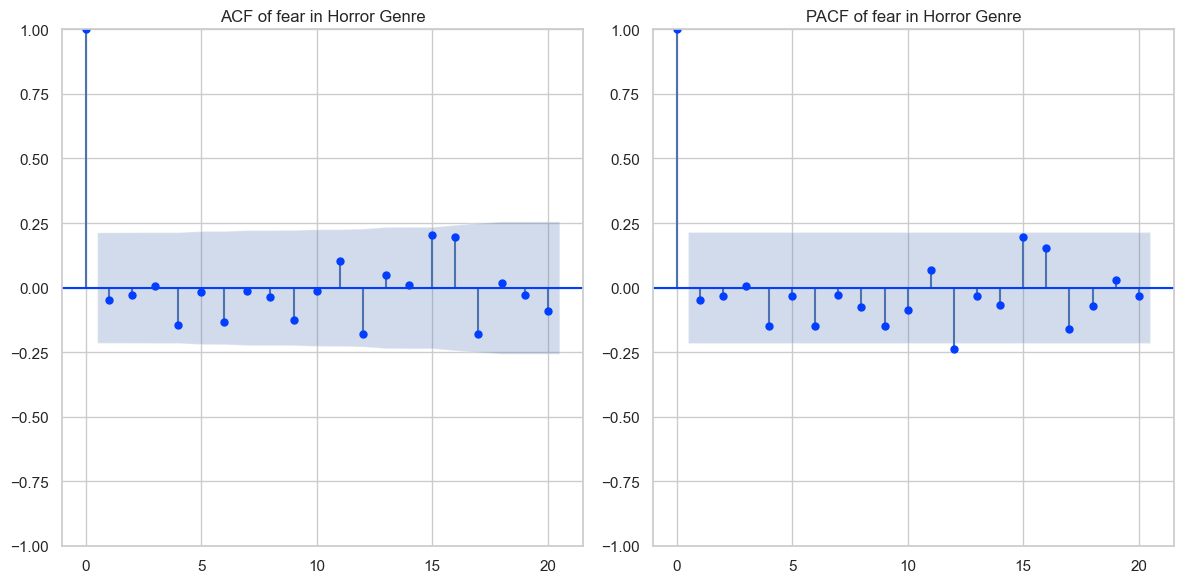

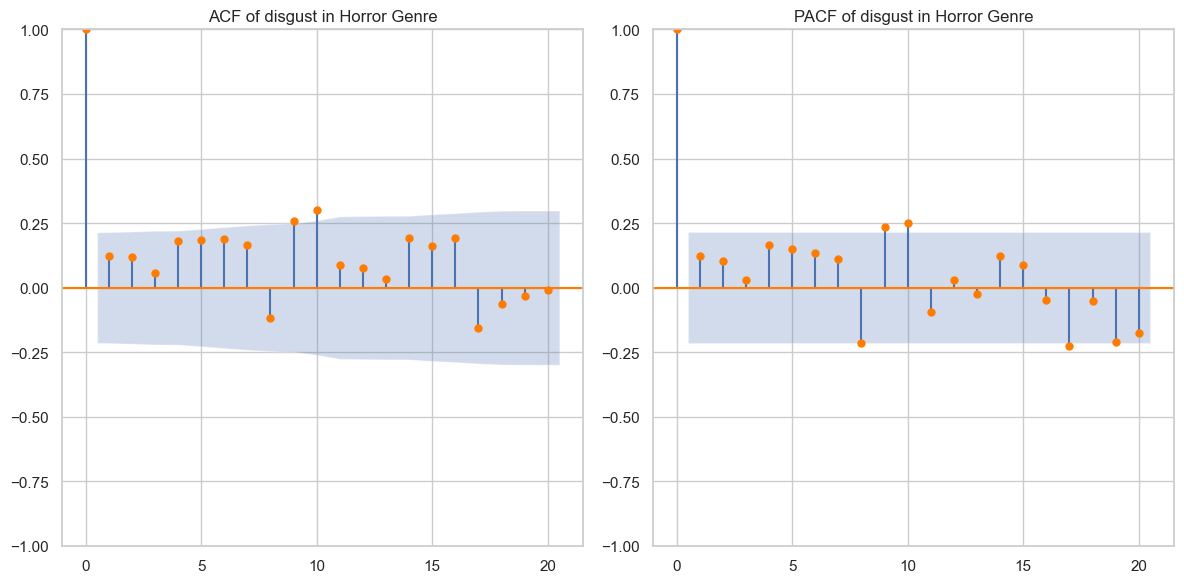

##########################################
 Performing Box-Jenkins Procedure for fear in Horror Genre
ADF Statistic: -9.4282225003187
p-value: 5.275646181909373e-16
Best ARIMA Order for fear in Horror Genre: (1, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in Horror Genre
ADF Statistic: -1.0727583574924553
p-value: 0.7258124187609352
The series is not stationary and needs to be differenced.
Best ARIMA Order for disgust in Horror Genre: (1, 1, 1)


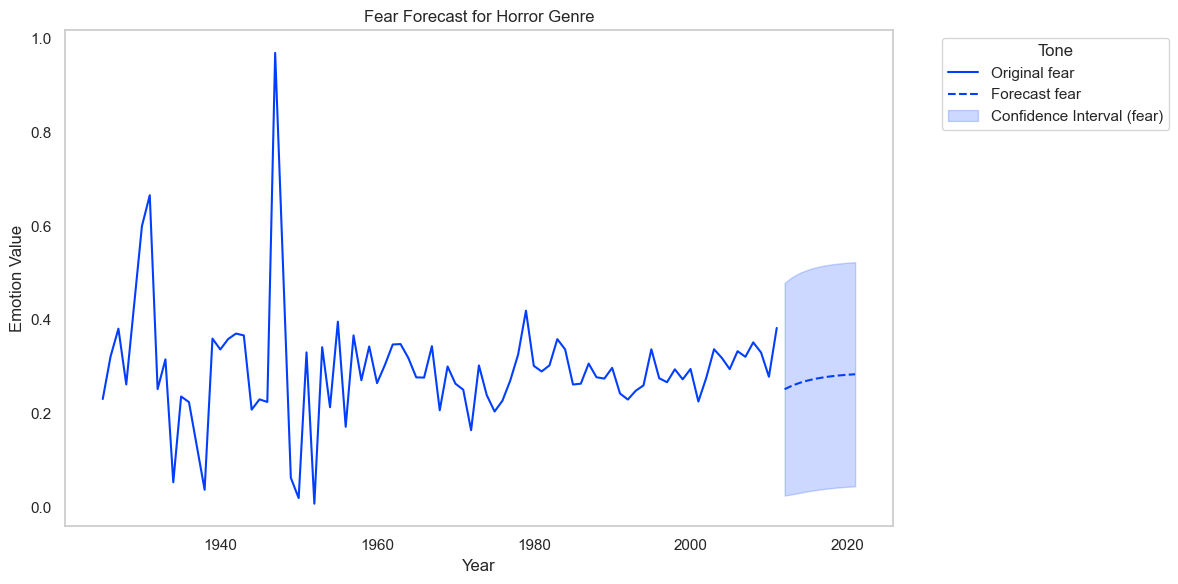

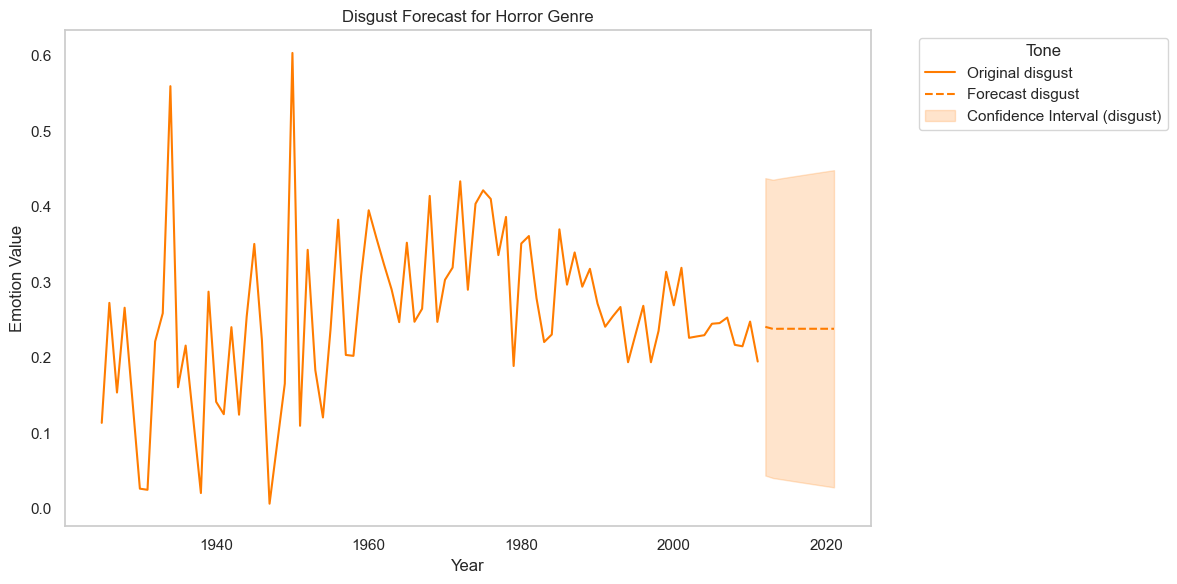

In [31]:
timeseries_plots(horror_df, "Horror")
horror_ts_results = box_jenkins_procedure(horror_df, "Horror")
horror_forecast_df = forecast_series(horror_df, "Horror", horror_ts_results)

#### Indie movies Time Series Analysis

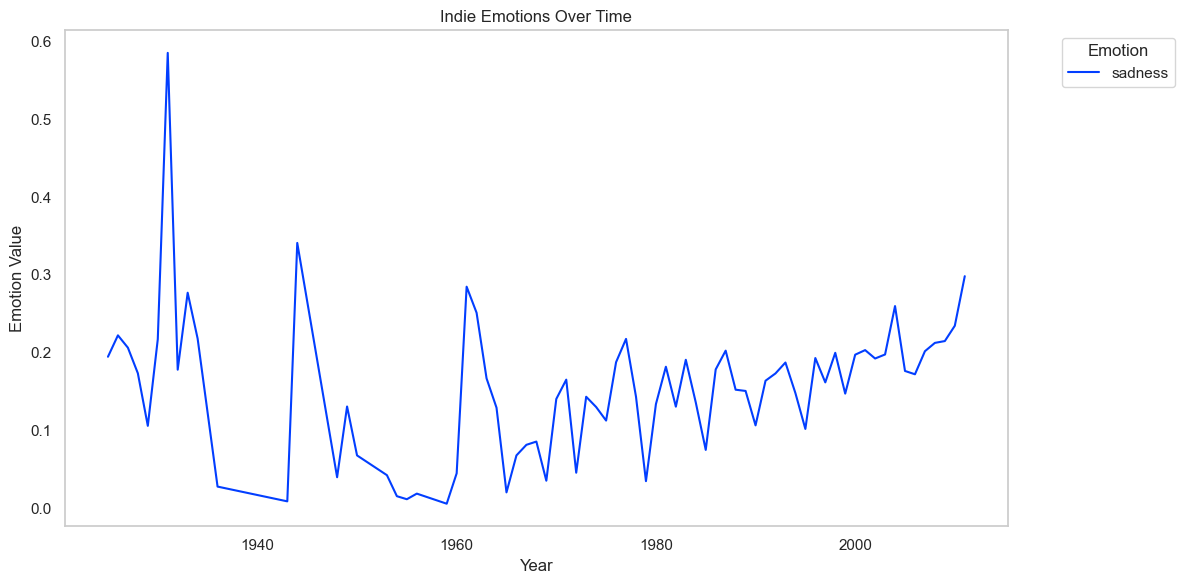

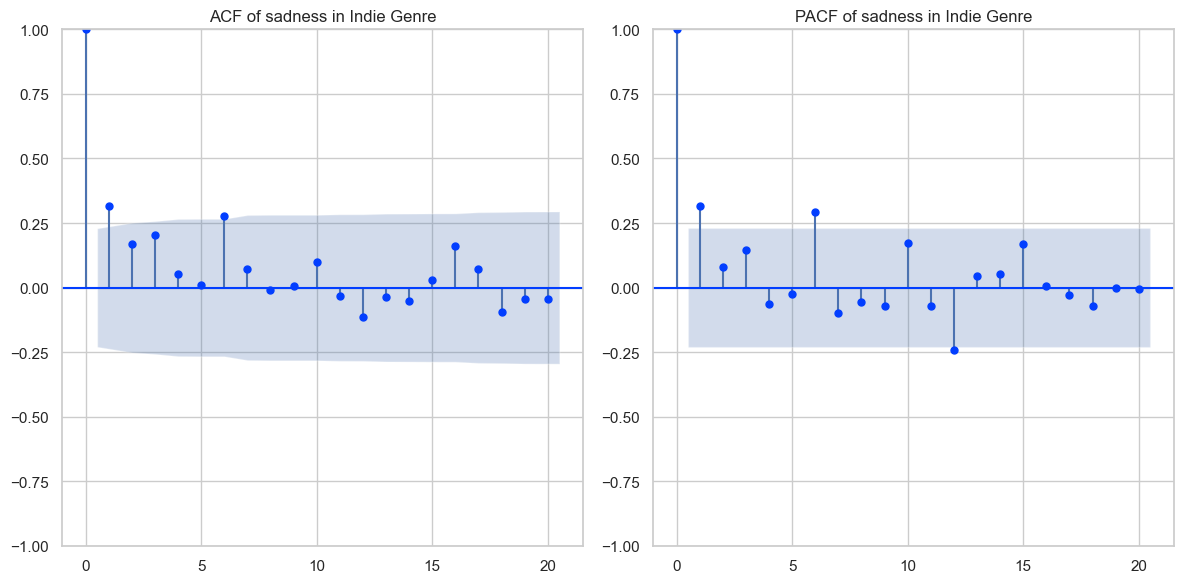

##########################################
 Performing Box-Jenkins Procedure for sadness in Indie Genre
ADF Statistic: -4.290242861905459
p-value: 0.00046181560314715746
Best ARIMA Order for sadness in Indie Genre: (3, 0, 2)


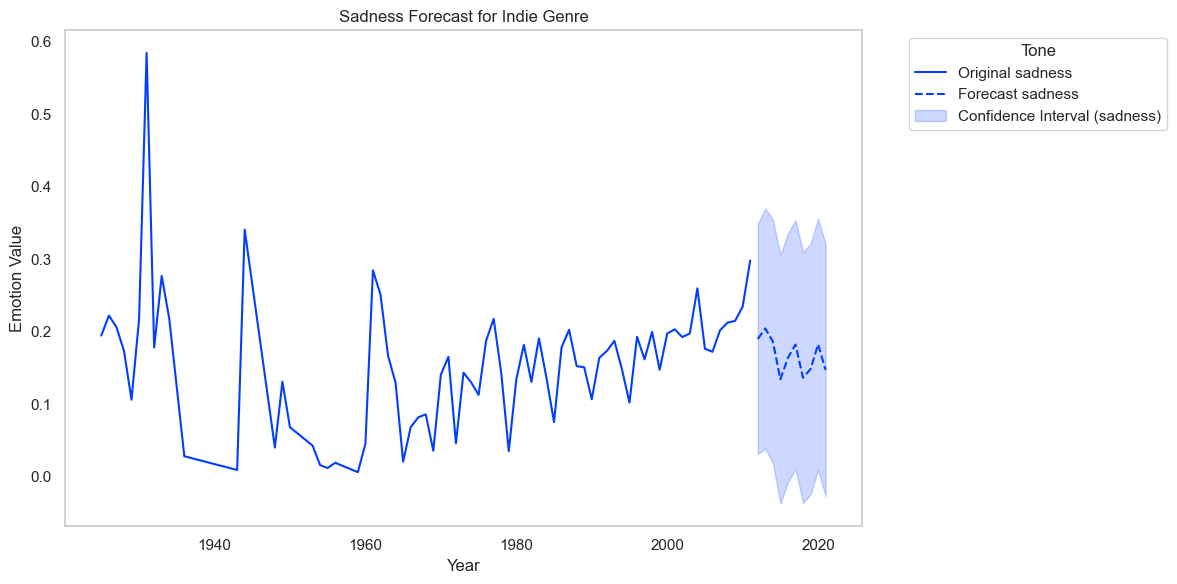

In [32]:
timeseries_plots(indie_df, "Indie")
indie_ts_results = box_jenkins_procedure(indie_df, "Indie")
indie_forecast_df = forecast_series(indie_df, "Indie", indie_ts_results)

#### Romance movies Time Series Analysis

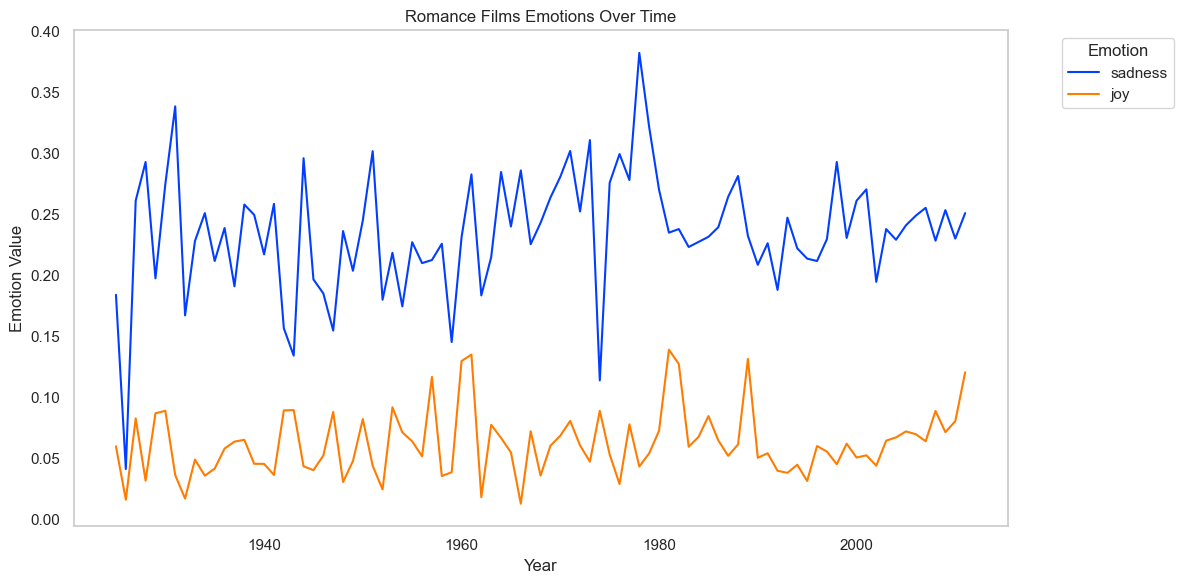

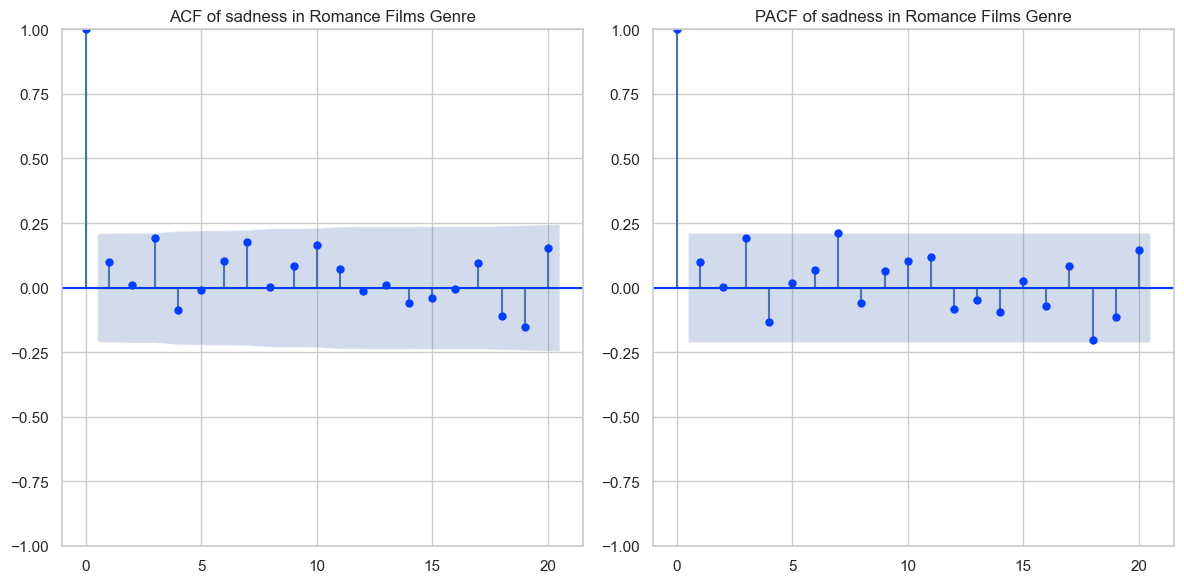

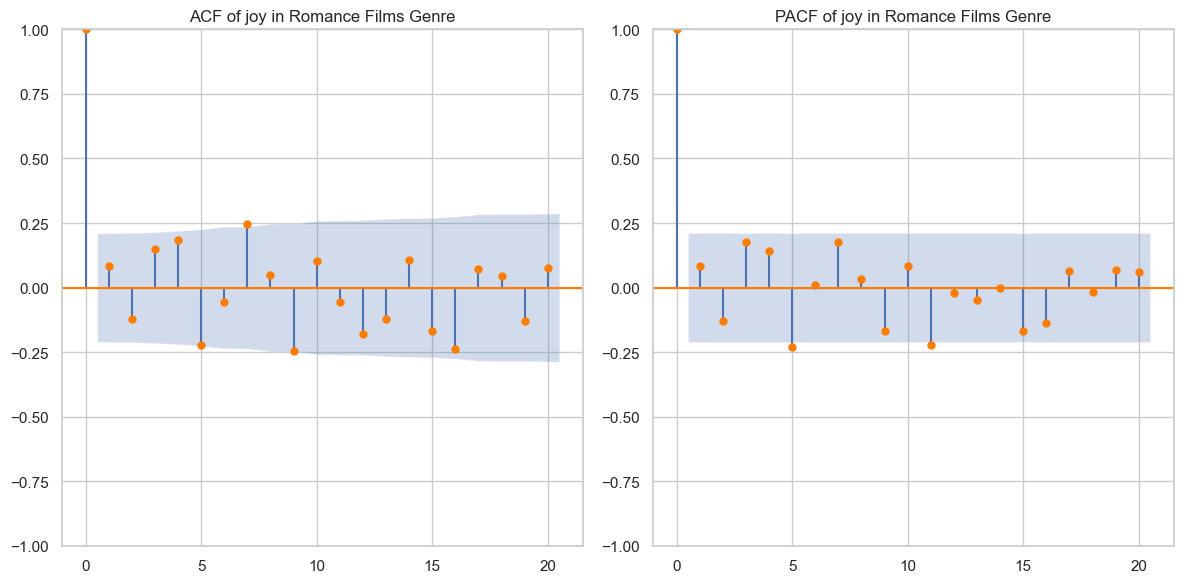

##########################################
 Performing Box-Jenkins Procedure for sadness in Romance Film Genre
ADF Statistic: -8.329339184936089
p-value: 3.4019021048001425e-13
Best ARIMA Order for sadness in Romance Film Genre: (1, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for joy in Romance Film Genre
ADF Statistic: -2.864368224350088
p-value: 0.04965115747924096
Best ARIMA Order for joy in Romance Film Genre: (2, 0, 2)


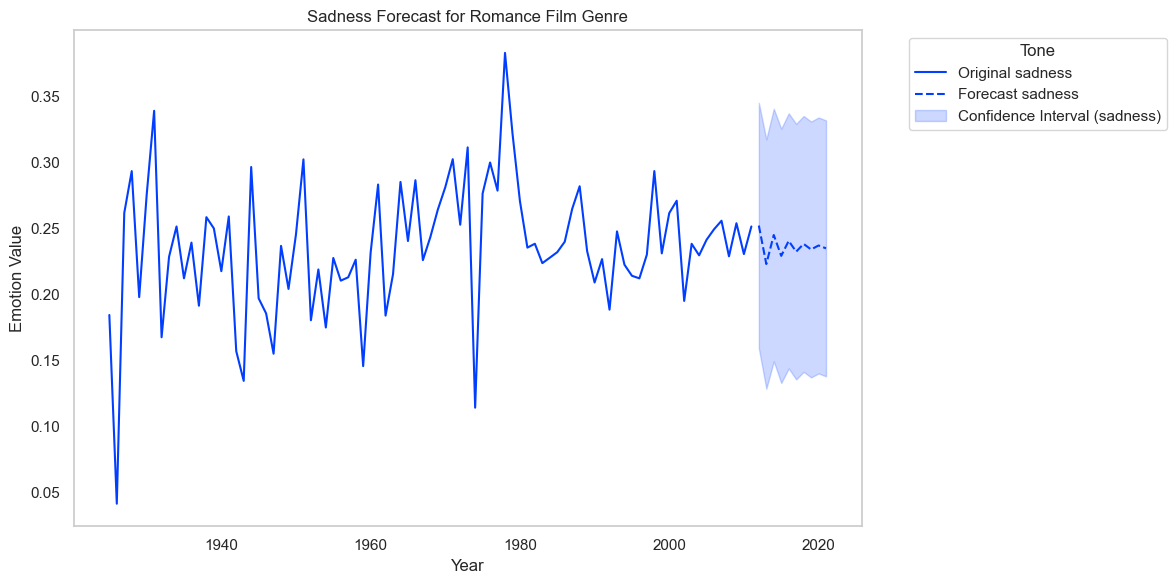

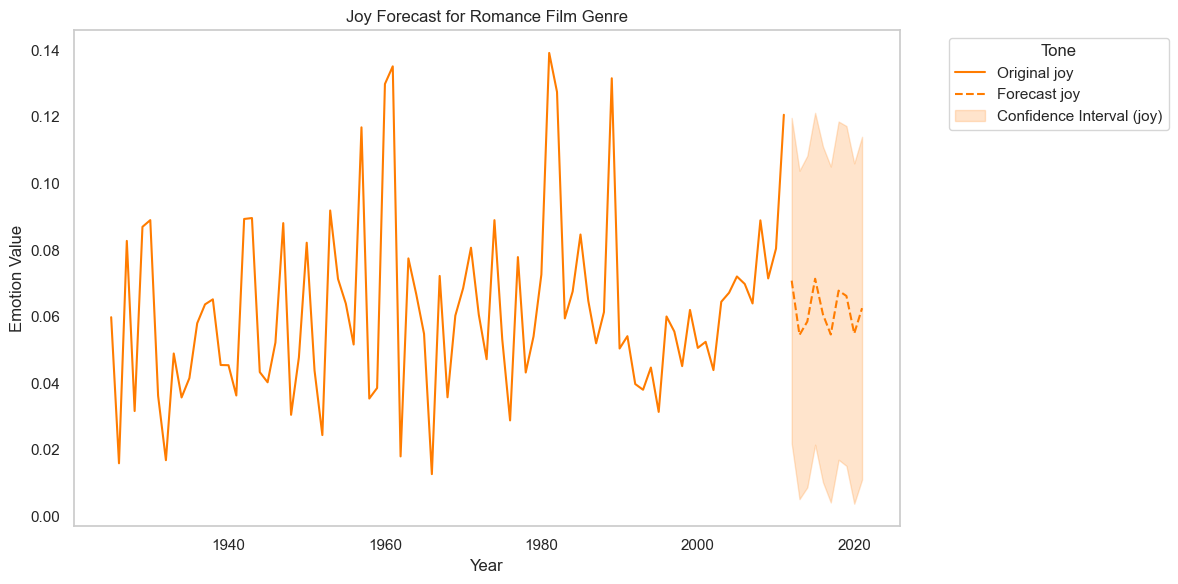

In [33]:
timeseries_plots(romance_film_df, "Romance Films")
romance_ts_results = box_jenkins_procedure(romance_film_df, "Romance Film")
romance_forecast_df = forecast_series(romance_film_df, "Romance Film", romance_ts_results)

#### Thriller movies Time Series Analysis

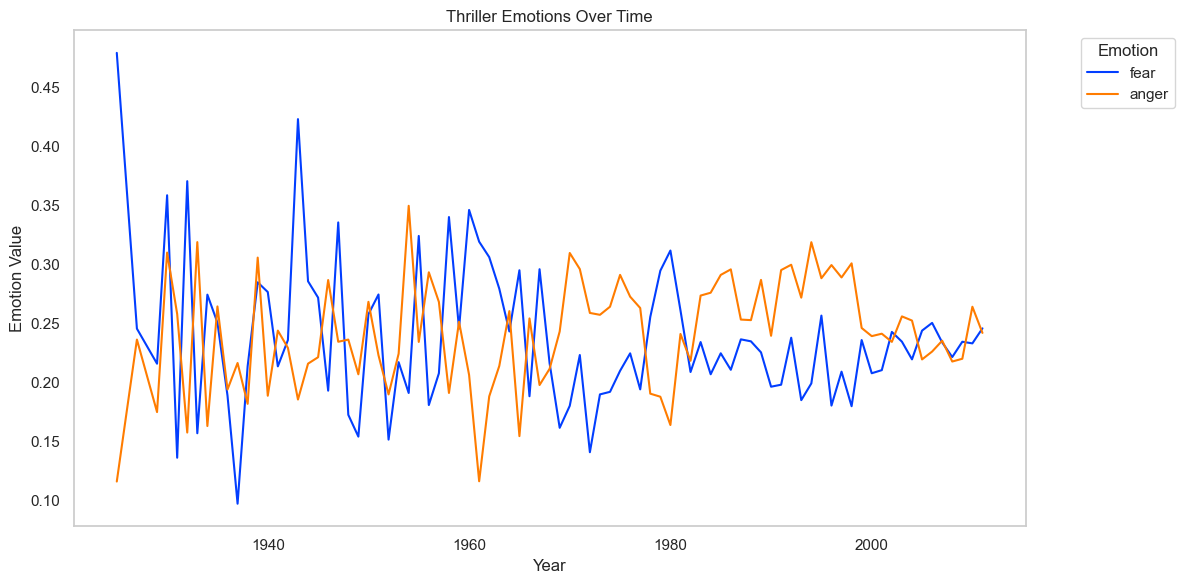

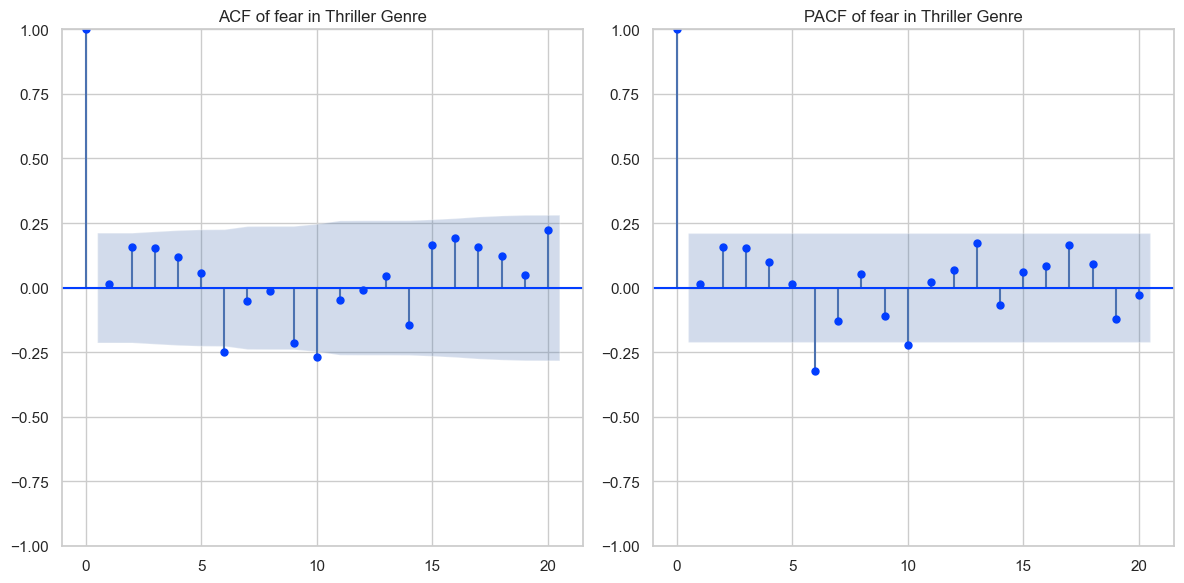

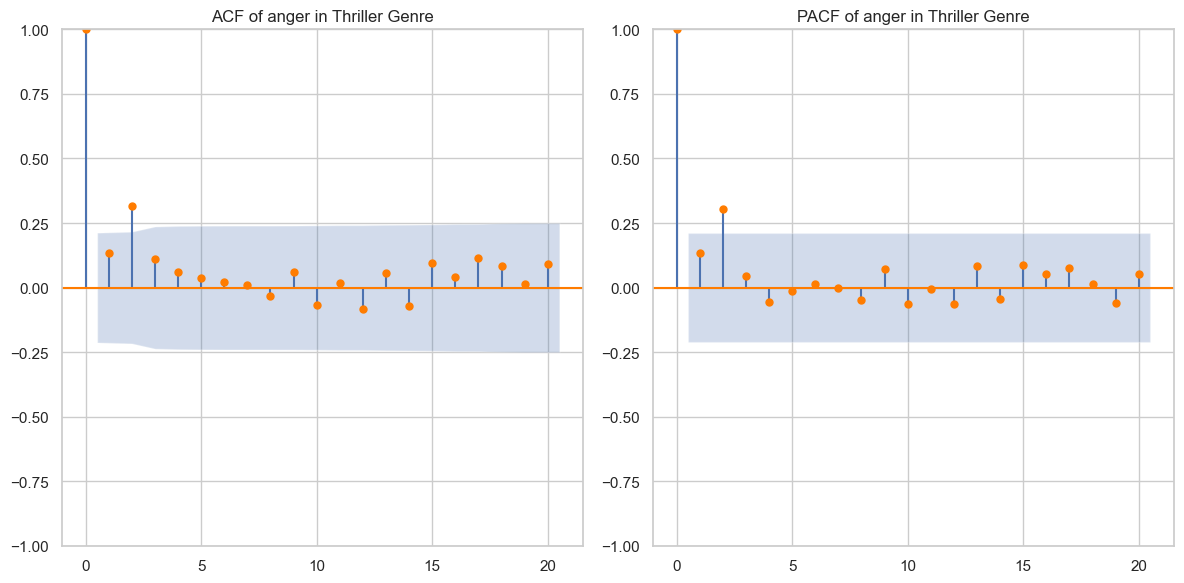

##########################################
 Performing Box-Jenkins Procedure for fear in Thriller Genre
ADF Statistic: -4.380649133353817
p-value: 0.00032113466060937806
Best ARIMA Order for fear in Thriller Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Thriller Genre
ADF Statistic: -4.398199262173898
p-value: 0.0002990183659113949
Best ARIMA Order for anger in Thriller Genre: (2, 0, 0)


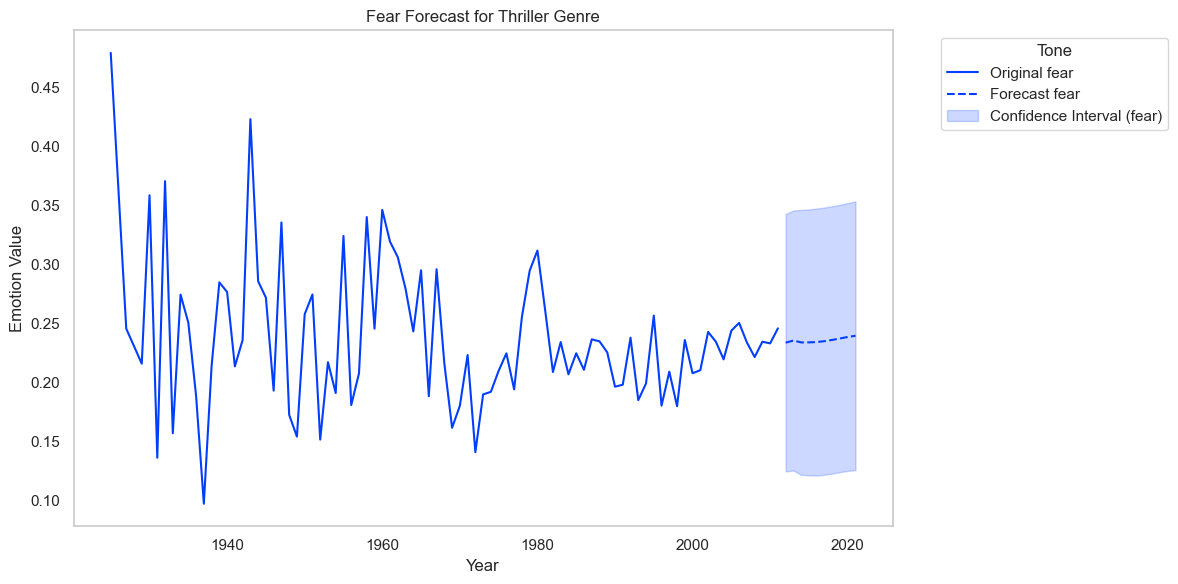

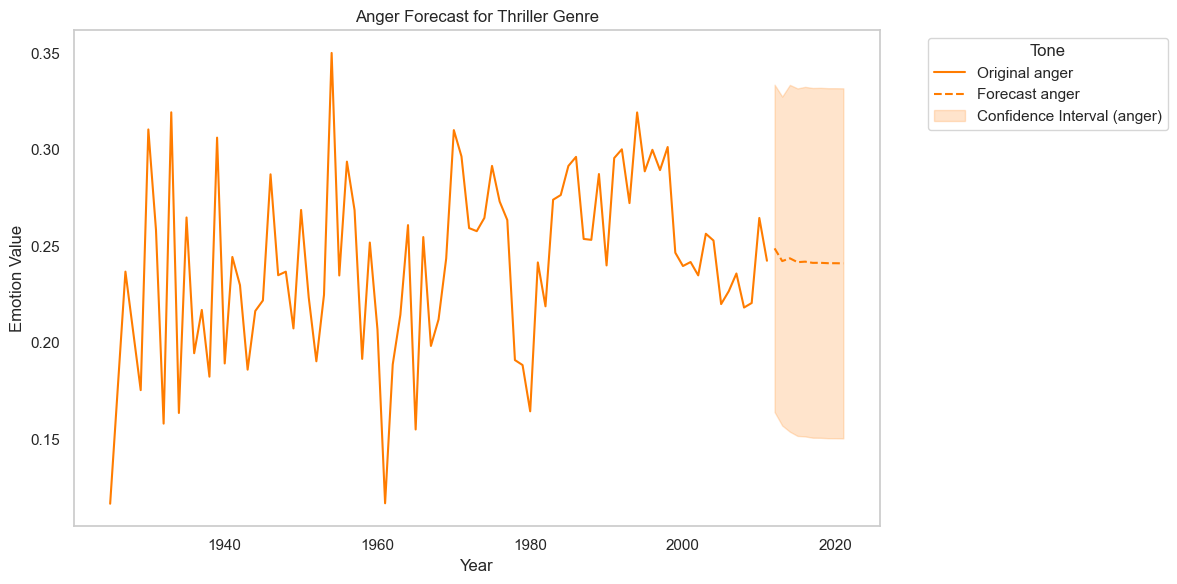

In [34]:
timeseries_plots(thriller_df, "Thriller")
thriller_ts_results = box_jenkins_procedure(thriller_df, "Thriller")
thriller_forecast_df = forecast_series(thriller_df, "Thriller", thriller_ts_results)

#### World Cinema movies Time Series Analysis

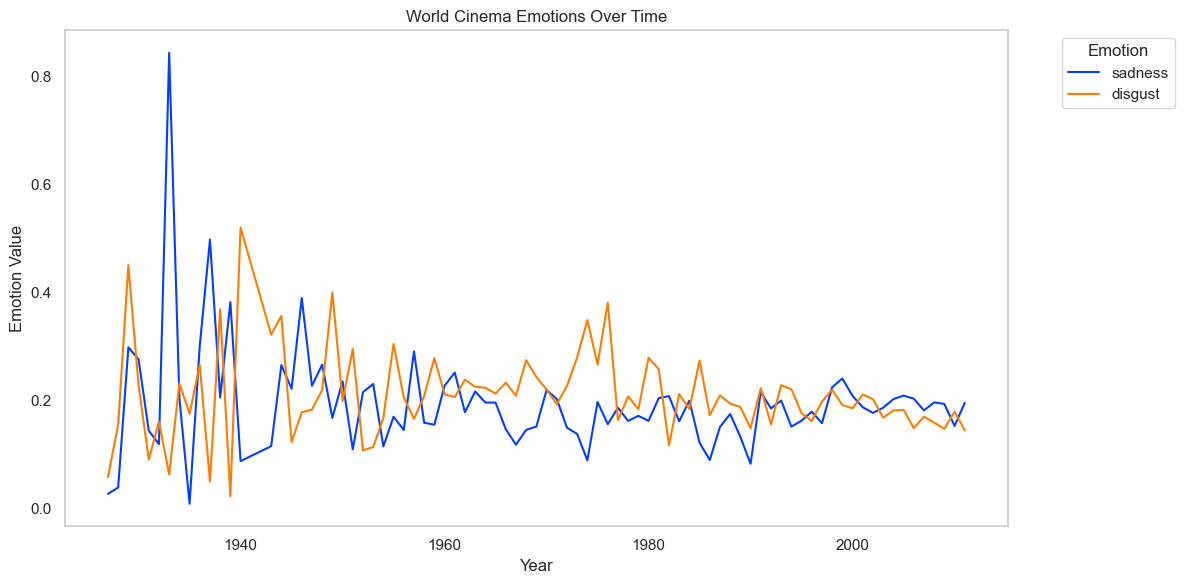

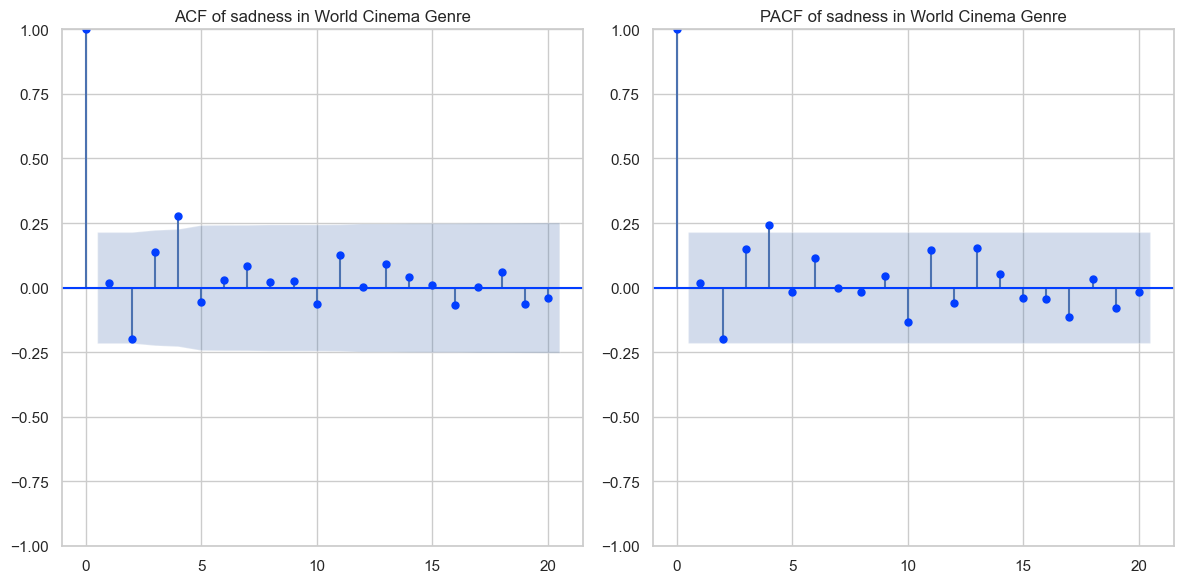

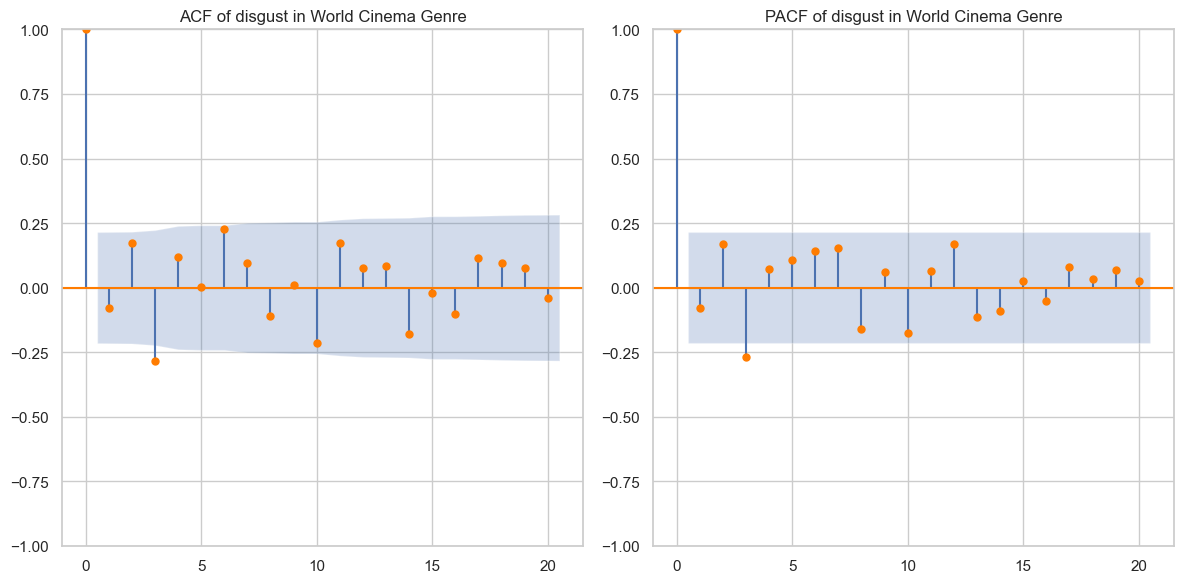

##########################################
 Performing Box-Jenkins Procedure for sadness in World Cinema Genre
ADF Statistic: -3.6754907309790994
p-value: 0.0044714087100456105
Best ARIMA Order for sadness in World Cinema Genre: (3, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in World Cinema Genre
ADF Statistic: -5.958683939337718
p-value: 2.0637716996936197e-07
Best ARIMA Order for disgust in World Cinema Genre: (3, 0, 0)


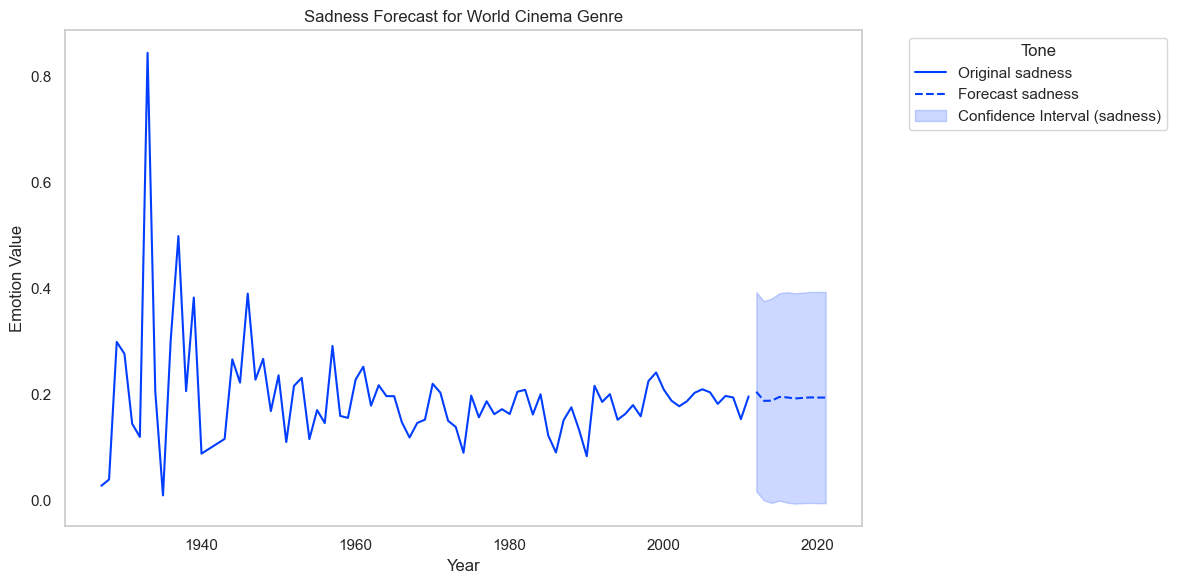

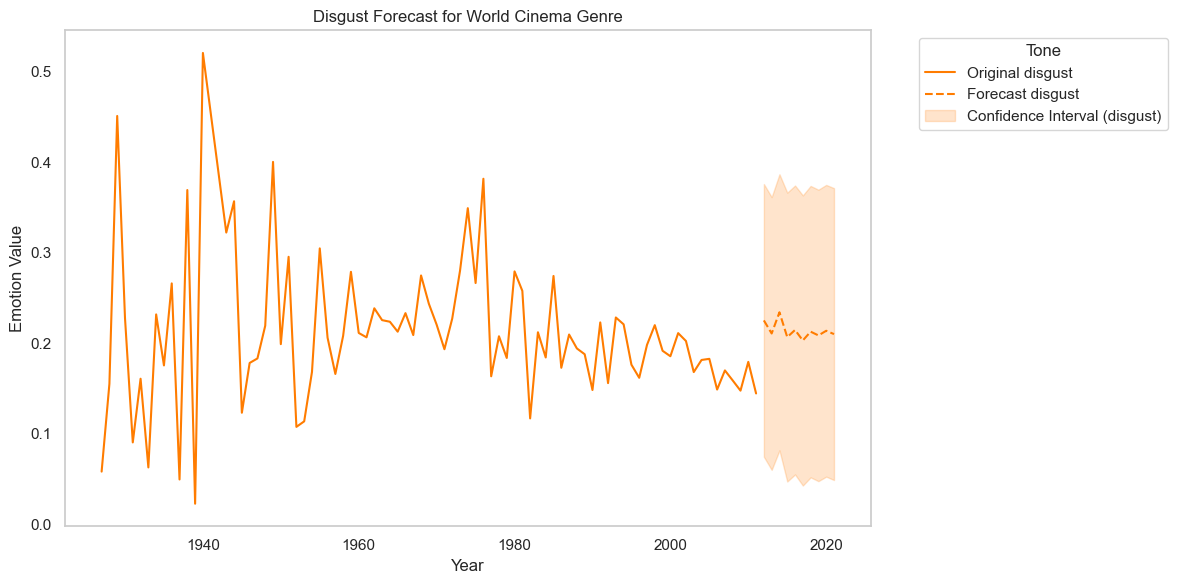

In [35]:
timeseries_plots(world_cinema_df, "World Cinema")
world_ts_results = box_jenkins_procedure(world_cinema_df, "World Cinema")
world_forecast_df = forecast_series(world_cinema_df, "World Cinema", world_ts_results)

# //TODO Interpretation and results 

Very interesting! Let's now look if there is a connection between the emotional tone of a movie and the components of the movie like its language or the actor traits of involved actors. First we will look at the question:
### How does the emotional tone of films influence the selection of actor traits, such as age and gender?

We will perform a regression analysis to see how the emotional tone of films influences the average age and gender of involved actors.

In [36]:
# Prepare the data for analysis
# Filter for columns needed for the analysis
character_df = df[['WikiID', 'merge_year', 'Genres', 'distilbert_emotions', 'ActorAge', 'ActorGender', 'ActorBirthDate', 'ActorGenderFlag']].copy()

# Drop rows without emotions, age or gender because they are not helpful here
print("Number of rows before droping: ", len(character_df))
character_df = character_df.dropna(subset=['distilbert_emotions', 'ActorAge', 'ActorGenderFlag'])
print("Number of rows after droping: ", len(character_df))

# Parse relevant attributes from string to correct datatype
#character_df['Genres'] = character_df['Genres'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorAge'] = character_df['ActorAge'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorGender'] = character_df['ActorGender'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorGenderFlag'] = character_df['ActorGenderFlag'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))

# Check if transformations worked properly
test_ages = character_df.iloc[0]['ActorAge']
print(test_ages)
test_gender = character_df.iloc[0]['ActorGender']
print(test_gender)
test_gender_flag = character_df.iloc[0]['ActorGenderFlag']
print(test_gender_flag)
print(f"Age entries: {len(test_ages)}, gender entries: {len(test_gender)}, gender flag entries: {len(test_gender_flag)}")


Number of rows before droping:  81771
Number of rows after droping:  30175
[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37.78852253927453, 30.0, 37.78852253927453, 37.78852253927453, 42.0, 57.0, 37.78852253927453, 66.0, 47.0, 58.0]
['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F']
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Age entries: 17, gender entries: 17, gender flag entries: 17


In [37]:
# Create aggregations for gender and age of actors
exploded_df = character_df.explode('ActorAge')
exploded_df = exploded_df.explode('ActorGenderFlag')

aggregated_df = exploded_df.groupby('WikiID').agg({
    "ActorAge": "mean",
    "ActorGenderFlag": "mean"
})

aggregated_df.rename(columns={
    'ActorAge': 'AgeAvg', 
    'ActorGenderFlag': 'GenderAvg'
}, inplace=True)

character_df = character_df.merge(aggregated_df, on='WikiID', how='left')

# Parse emotions from string to dictionary
character_df['distilbert_emotions'] = character_df['distilbert_emotions'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

# Check the result
test_emotions = character_df.iloc[0]['distilbert_emotions']
print(type(test_emotions))

<class 'dict'>


In [38]:
# Add each emotion as column
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
for emotion in emotions:
    character_df[emotion] = character_df['distilbert_emotions'].apply(lambda x: x[emotion])
character_df.head()

WikiID  merge_year                                             Genres  \
0   975900        2001  [Thriller, Science Fiction, Horror, Adventure,...   
1  9363483        1987  [Thriller, Erotic thriller, Psychological thri...   
2   261236        1983                                            [Drama]   
3  6631279        1997  [Romantic comedy, Ensemble Film, Comedy-drama,...   
4   171005        1989  [Costume drama, War film, Epic, Period piece, ...   

                                 distilbert_emotions  \
0  {'disgust': 0.5021221041679382, 'fear': 0.3510...   
1  {'anger': 0.5024036765098572, 'disgust': 0.324...   
2  {'anger': 0.3256497378461063, 'disgust': 0.163...   
3  {'sadness': 0.9155038595199585, 'neutral': 0.0...   
4  {'neutral': 0.6794102787971497, 'surprise': 0....   

                                            ActorAge  \
0  [42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....   
1                                       [32.0, 26.0]   
2                                 [32.0, 32.0, 35.0]   
3               [25.0, 33.0, 37.0, 35.0, 33.0, 48.0]   
4  [28.0, 51.0, 33.0, 26.0, 30.0, 32.0, 58.0, 53....   

                                         ActorGender  \
0  [F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...   
1                                             [M, F]   
2                                          [F, M, M]   
3                                 [M, F, F, M, F, F]   
4  [M, M, M, M, F, M, M, M, M, M, F, M, M, F, M, ...   

                                      ActorBirthDate  \
0  [Timestamp('1958-08-26 00:00:00'), Timestamp('...   
1  [Timestamp('1954-05-08 00:00:00'), Timestamp('...   
2  [Timestamp('1950-06-20 00:00:00'), Timestamp('...   
3  [Timestamp('1971-09-15 00:00:00'), Timestamp('...   
4  [Timestamp('1960-12-10 00:00:00'), Timestamp('...   

                                     ActorGenderFlag     AgeAvg  GenderAvg  \
0  [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  42.126711   0.352941   
1                                             [0, 1]  29.000000   0.500000   
2                                          [1, 0, 0]  33.000000   0.333333   
3                                 [0, 1, 1, 0, 1, 1]  35.166667   0.666667   
4  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...  45.513739   0.190476   

    disgust      fear     anger   neutral   sadness  surprise       joy  
0  0.502122  0.351022  0.065147  0.057085  0.018771  0.004086  0.001766  
1  0.324022  0.032032  0.502404  0.096385  0.037811  0.005438  0.001907  
2  0.163747  0.002405  0.325650  0.440068  0.025255  0.005851  0.037024  
3  0.021709  0.010488  0.006082  0.042634  0.915504  0.002163  0.001421  
4  0.004746  0.003841  0.016094  0.679410  0.057925  0.129912  0.108072

The emotions sum up to one, so there is multicoloniartiy between the variables. Therefore to create a meaningful analysis we have to drop a class. Let's first do a quick correlation analysis to see if there is one emotion which is strongly correlated to others, so we can drop it.

In [39]:
# Filter
emotion_corr_df = character_df[emotions]

# Do correlation analysis
emotion_corr_df.corr()

disgust      fear     anger   neutral   sadness  surprise       joy
disgust   1.000000 -0.224354 -0.055964 -0.211494 -0.242464 -0.185363 -0.176413
fear     -0.224354  1.000000 -0.206568 -0.268345 -0.234403 -0.056546 -0.162655
anger    -0.055964 -0.206568  1.000000 -0.291715 -0.273985 -0.157576 -0.204393
neutral  -0.211494 -0.268345 -0.291715  1.000000 -0.210060 -0.032004  0.100285
sadness  -0.242464 -0.234403 -0.273985 -0.210060  1.000000 -0.092891 -0.075215
surprise -0.185363 -0.056546 -0.157576 -0.032004 -0.092891  1.000000 -0.011244
joy      -0.176413 -0.162655 -0.204393  0.100285 -0.075215 -0.011244  1.000000

There doesn't seem to be a clear candidate, so we will drop the semantically least interesting emotion: neutral.

In [40]:
character_df = character_df.drop(labels=['neutral'], axis=1)

We will now regress AvgAge and AvgGender using all the emotions leaving out the 'neutral' tone for multicollinearity purpose.

The effect of the neutral emotion is therefore represented by the intercept.
The coeffients of the remaining tones will represent the effect of a 1-unit increase in the proportion of that tone relative to the excluded category (neutral) on the dependet variable, while holding the total sum of probabilities fixed at 1.

In [41]:
# Model for average age
age_mod = smf.ols(formula='AgeAvg ~ disgust + fear + anger + sadness + surprise + joy', data=character_df)
age_res = age_mod.fit()
print(age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     15.27
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           1.48e-17
Time:                        17:58:23   Log-Likelihood:            -1.0081e+05
No. Observations:               30175   AIC:                         2.016e+05
Df Residuals:                   30168   BIC:                         2.017e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.5932      0.153    252.223      0.0

We see that that the all the tones except 'fear' seems significant although the R^2 metric is very low (0.03). That shows that the model does not explain well the variance of the dependent variable, which means that knowing only the emotional score of the film is not enough information to predict efficiently the average actor age. To do that we probably need more predictors like Genres, Languages, Movie Character traits etc. 

Nonetheless, the coefficients tell us some insight on how the tone influence the Avg Age: All of them are negative and significant, meaning that an increase in proportion of those tones relative to the neutral emotion, on average decrease the Avg Age of the film cast. So we can see that for films with stronger emotions, on average younger actors are chosen. We also see differences between the different emotions. Even though all coefficients are negative, the ones for joy anger and disgust are noticeably higher than the ones of the other emotions.

In [42]:
# Model for average gender
gender_mod = smf.ols(formula='GenderAvg ~ disgust + fear + anger + sadness + surprise + joy', data=character_df)
gender_res = gender_mod.fit()
print(gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     89.66
Date:                Thu, 19 Dec 2024   Prob (F-statistic):          5.67e-112
Time:                        17:58:23   Log-Likelihood:                 3147.5
No. Observations:               30175   AIC:                            -6281.
Df Residuals:                   30168   BIC:                            -6223.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3046      0.005     62.415      0.0

Every coefficient is significant, The R^2 metric is very low (0.018) bringing the same result as before: we need more significan predictors to explain and model the proportion of female/male in a cast. 

Nonetheless,  the coefficients tell us some insight on how the tone influence the Avg Gender: Anger is negative, so an increase in proportion of the anger tone relative to the neutral tone decreases the proportion of female actors in a cast.
All the other coefficients are positive, meaning the their increase in proportion compare to 'neutral' increase the proportion of female in the cast.

Interesting! So even though we can't explain the average age and gender of actors purely based on emotions, what is expected, we still see how emotions influence these actor traits. Now we want to switch our focus away from the actors involved in the movie and look at the film languages. We are interested in the connection between present emotions in a movie and the languages a movie is available in. Therefore we try to answer the question:
### Does the emotional tone of films differ between movies in different languages?

In [43]:
df_languages = df.copy()
df_languages["Languages"] = df_languages["Languages"].apply(lambda x: ast.literal_eval(x))
df_languages["nrclex_emotions"] = df_languages["nrclex_emotions"].apply(lambda x: conv_to_dict(x))
df_languages["roberta_emotions"] = df_languages["roberta_emotions"].apply(lambda x: conv_to_dict(x))
df_languages["distilbert_emotions"] = df_languages["distilbert_emotions"].apply(lambda x: conv_to_dict(x))

In [44]:
# We were getting some errors printing languages and seems there are some invalid unicode characters
def is_invalid_unicode(text: str):
    """Check if text contains invalid unicode characters"""
    try:
        text.encode('utf-8').decode('utf-8')
        return False
    except UnicodeError:
        return True
    
def clean_lang_list(languages: list[str]):
    """Remove invalid languages from a list of languages"""
    return [l for l in languages if not is_invalid_unicode(l)]

df_languages["Languages"] = df_languages["Languages"].apply(clean_lang_list)

In [45]:
no_lang_count = len(df_languages[df_languages["Languages"].apply(lambda x: len(x) == 0)])
print(f"Number of movies with no language: {no_lang_count}")

# Percentage of movies with no language
print(f"Percentage of movies with no language: {no_lang_count / len(df_languages) * 100:.2f}%")

Number of movies with no language: 13868
Percentage of movies with no language: 16.96%


In [46]:
# Drop all movies that don't have a labelled language
df_languages[df_languages["Languages"].apply(lambda x: len(x) < 0)]

# Look at the distribution of languages over all movies
language_count = df_languages['Languages'].explode().value_counts()
print(language_count)

English Language                        40914
Hindi Language                           3745
Spanish Language                         3675
French Language                          3422
Silent film                              3183
                                        ...  
Australian Aboriginal Pidgin English        1
Krio Language                               1
Tok Pisin Language                          1
Pawnee Language                             1
Kriolu                                      1
Name: Languages, Length: 206, dtype: int64


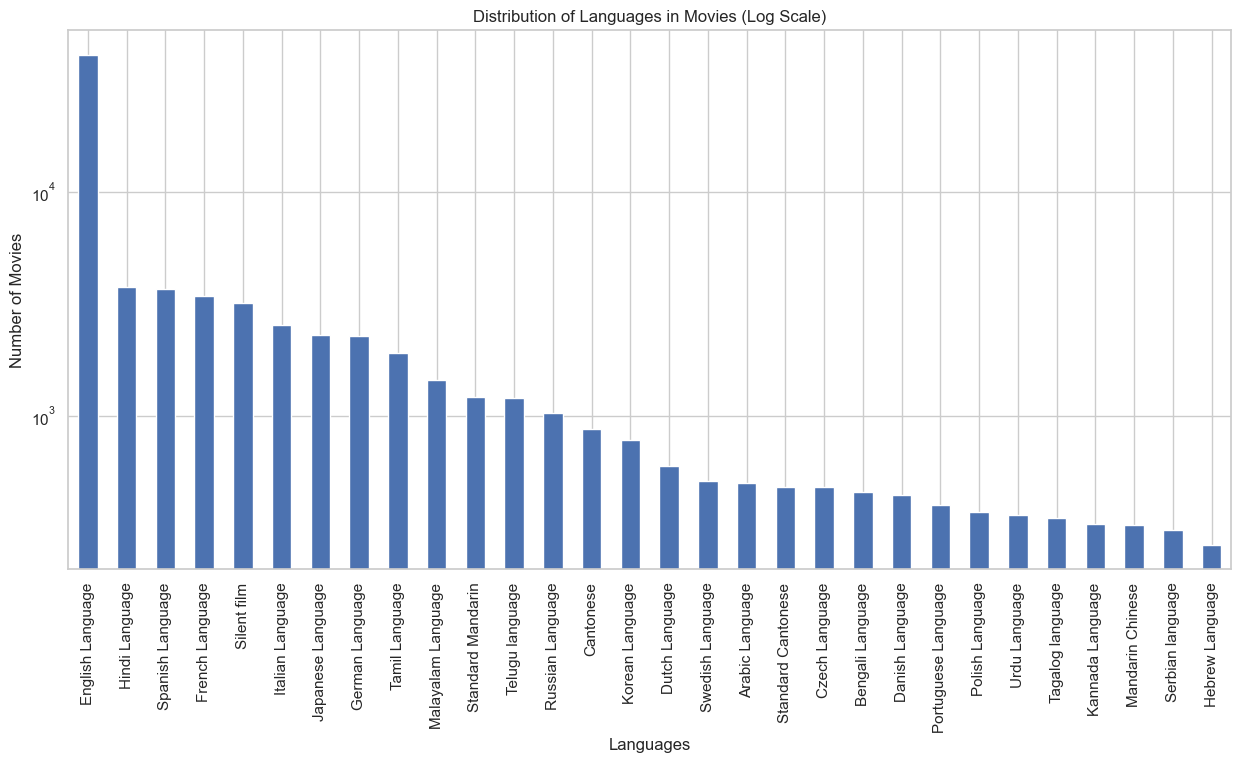

In [47]:
language_count[:30].plot(kind='bar', figsize=(15, 7), logy=True)
plt.title('Distribution of Languages in Movies (Log Scale)')
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.show()

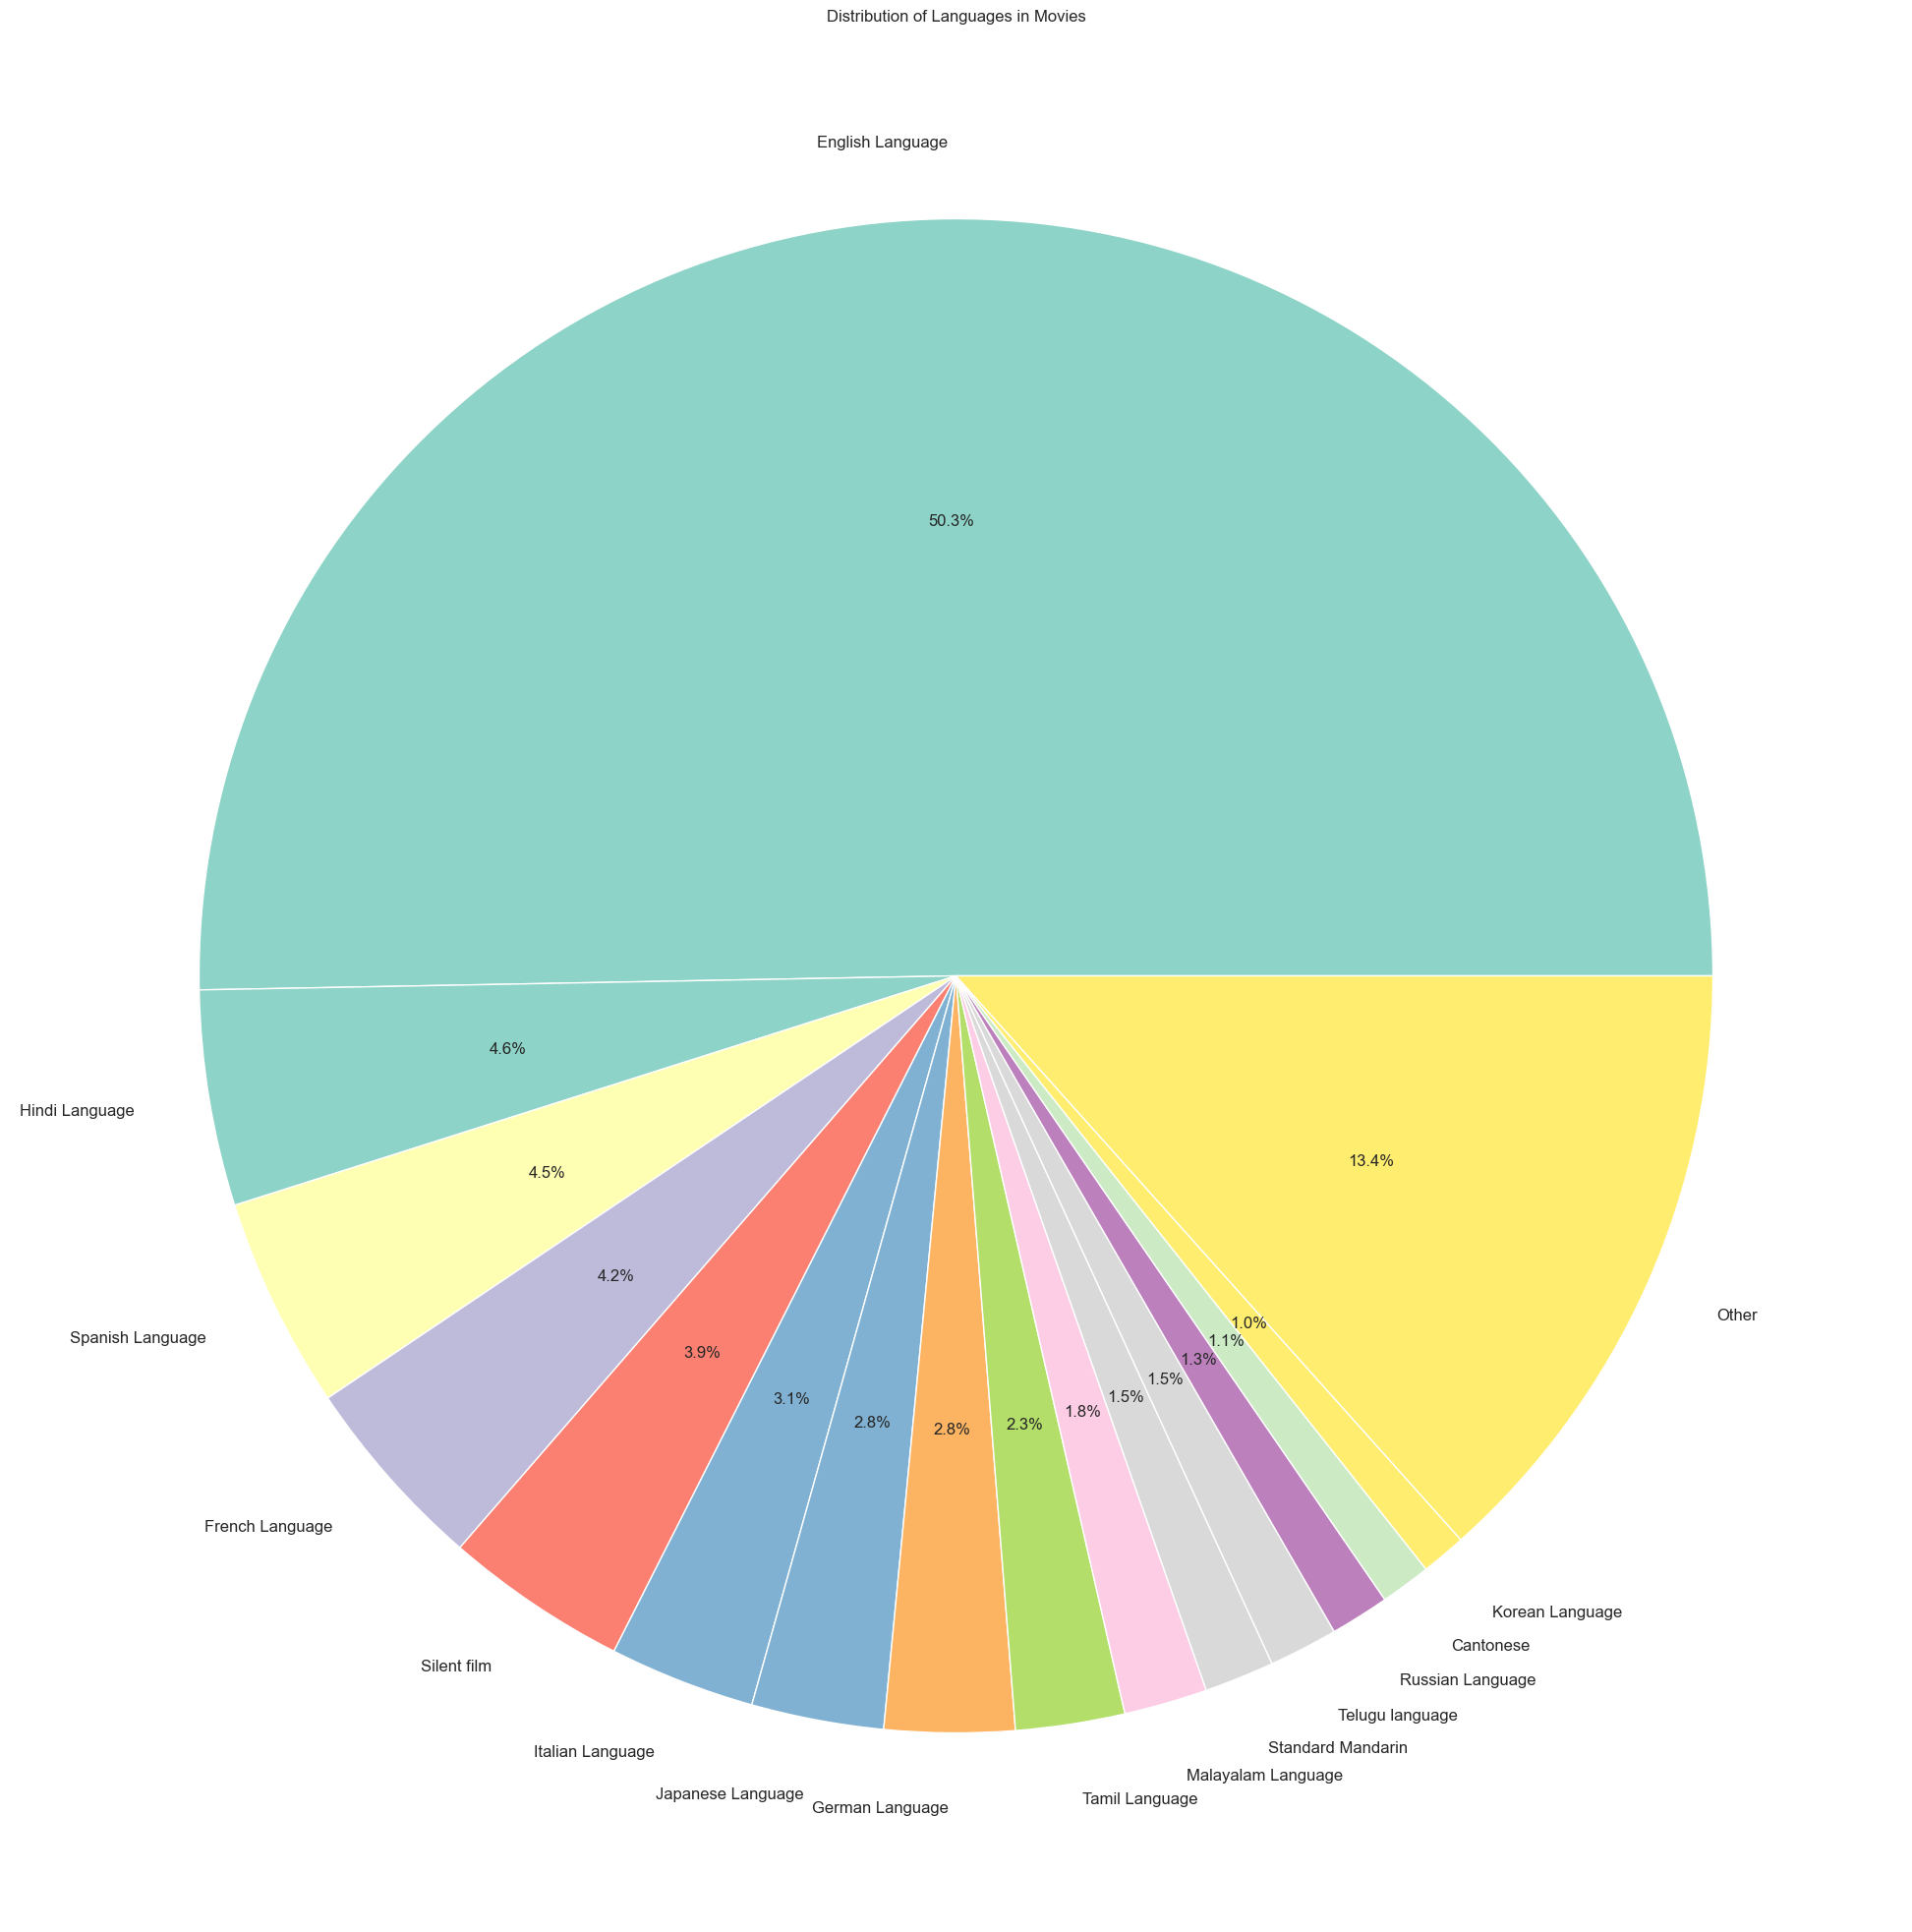

In [48]:
# Create a pie chart of the top 15 languages plus "Other"
plt.figure(figsize=(25, 25))

# Get top 15 languages and sum the rest into "Other"
top_15 = language_count[:15]
other = pd.Series({'Other': language_count[15:].sum()})
plot_data = pd.concat([top_15, other])

colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))

plt.pie(plot_data, labels=plot_data.index, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Distribution of Languages in Movies')
plt.show()

As an explicit choice, we will keep silent films going forward because there may be some emotional profile differences for films with NO dialogue


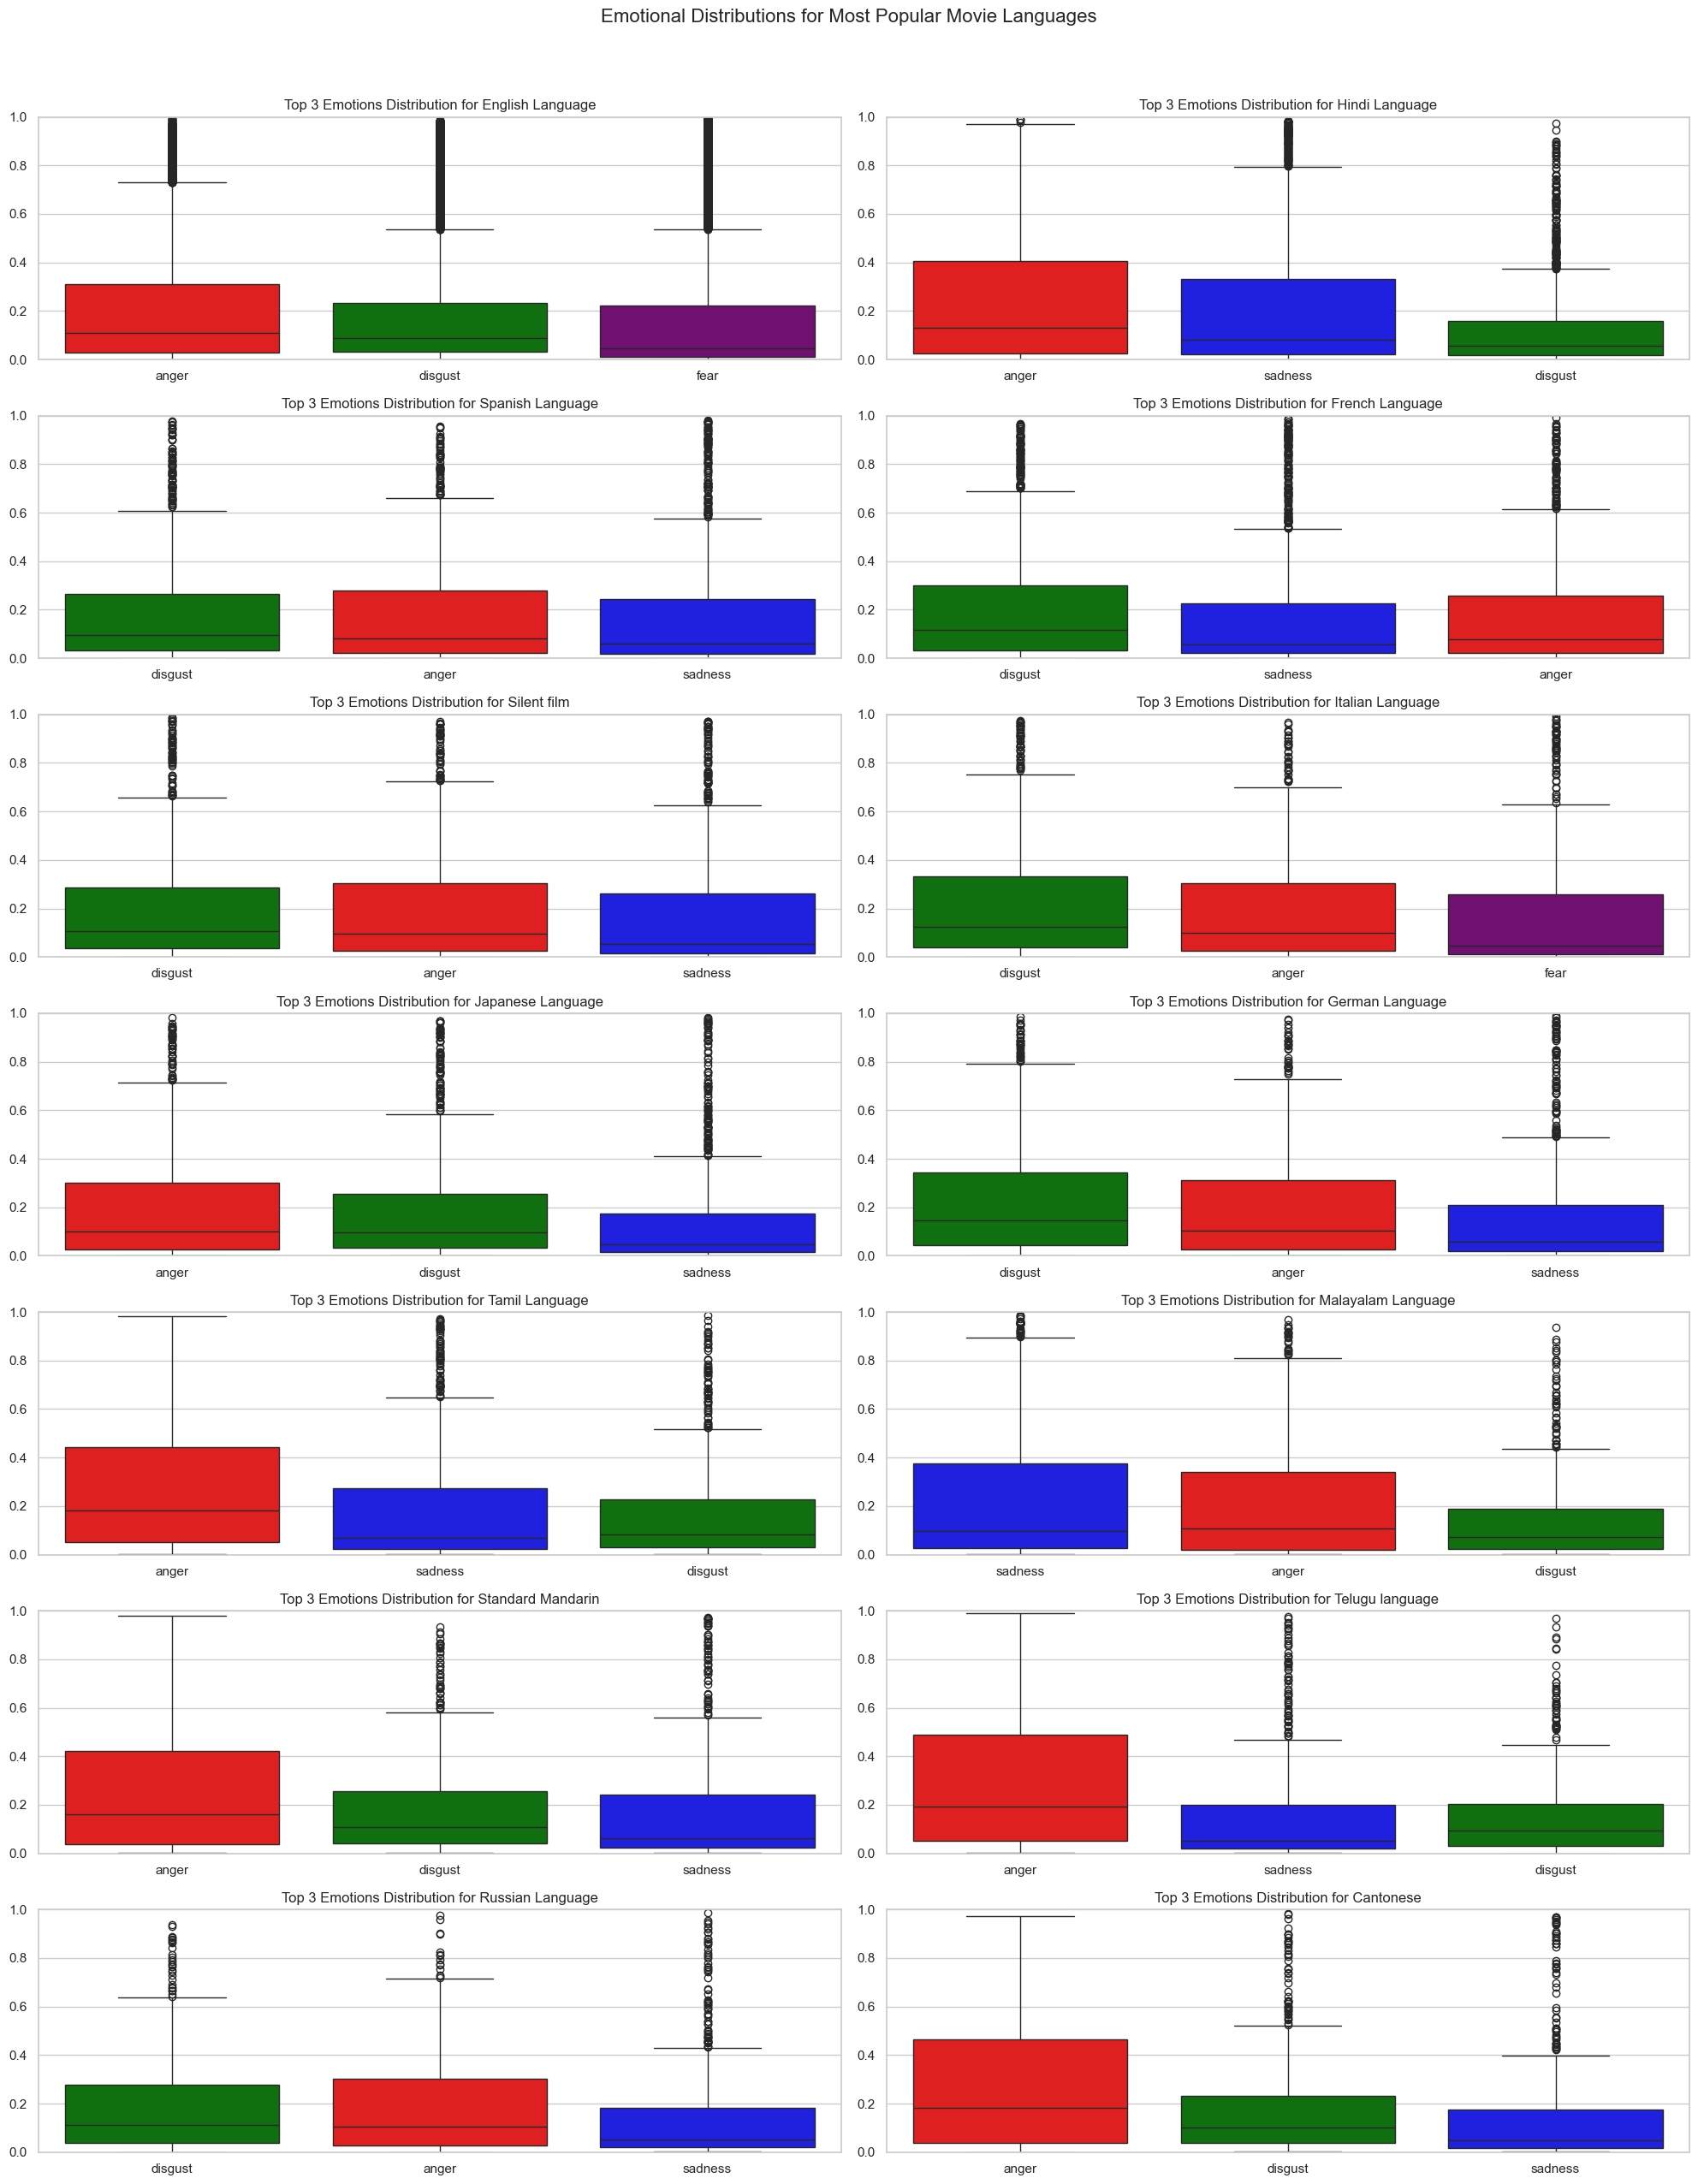

In [49]:
# Define a color palette for the emotions
emotion_palette = {
  'anger': 'red',
  'disgust': 'green',
  'sadness': 'blue',
  'fear': 'purple',
  'joy': 'yellow',
  'surprise': 'orange'
}

# We analyze the emotions of the top 14 languages
top_languages = language_count[:14].index

# For each language, get all the movies that belong to it and plot emotion distributions
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 25))
axes = axes.flatten()

for i, lang in enumerate(top_languages):
  movies_in_lang = df_languages[df_languages['Languages'].apply(lambda x: lang in x)]
  distilbert_emotions = movies_in_lang['distilbert_emotions'].dropna()
  
  # Convert list of dicts to DataFrame for easier plotting
  distilbert_emotions_df = pd.DataFrame(list(distilbert_emotions))

  # Remove neutral emotion
  distilbert_emotions_df = distilbert_emotions_df.drop('neutral', axis=1)

  # Get top 3 emotions by mean value
  top_3_emotions_distilbert = distilbert_emotions_df.mean().nlargest(3).index
  
  # Plot boxplot for this language with only top 3 emotions
  sns.boxplot(data=distilbert_emotions_df[top_3_emotions_distilbert], ax=axes[i], palette=emotion_palette)
  axes[i].set_title(f'Top 3 Emotions Distribution for {lang}')
  axes[i].set_ylim(0, 1)

plt.suptitle('Emotional Distributions for Most Popular Movie Languages', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [53]:
EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

def convert_to_percentage(emotions: dict) -> dict:
    """
    Convert emotional decimal values to percentages.
    """
    return {k: v * 100 for k, v in emotions.items()}

def prepare_data_for_analysis(df_to_prepare: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare the data for statistical analysis by:
    1. Expanding the language lists into separate rows
    2. Creating emotion columns from the dictionary
    3. Filtering for languages with sufficient data
    """

    df_new = df_to_prepare.copy()

    # Get rid of rows without emotion data
    df_new = df_new[df_new['distilbert_emotions'].apply(lambda x: isinstance(x, dict) and x != {})]

    # Multiply all the emotions by 100 so we can work with percentages
    df_new['distilbert_emotions'] = df_new['distilbert_emotions'].apply(convert_to_percentage)

     # Explode the Languages column to create separate rows for each language
    df_new = df_new.explode('Languages').reset_index(drop=True)

    # Create separate columns for each emotion
    for emotion in EMOTIONS:
        df_new[emotion] = df_new['distilbert_emotions'].apply(lambda x: x.get(emotion, np.nan))

    # Filter for languages with at least 100 movies
    language_counts = df_new['Languages'].value_counts()
    valid_languages = language_counts[language_counts >= 100].index
    df_filtered = df_new[df_new['Languages'].isin(valid_languages)]
    
    return df_filtered

REGRESSION_MODEL = "C(Languages, Treatment(reference='English Language'))"

def run_individual_regressions(df_reg: pd.DataFrame):
    """
    Perform separate regression analyses for each emotion.
    """
    
    results = {}
    for emotion in EMOTIONS:
        model = sm.OLS.from_formula(f"{emotion} ~ {REGRESSION_MODEL}", data=df_reg).fit()
        results[emotion] = {
            'r_squared': model.rsquared,
            'significant_effects': model.pvalues[model.pvalues < 0.05],
            'significant_params': model.params[model.pvalues < 0.05],
            'model': model
        }

    return results

# Prepare the data
df_analysis = prepare_data_for_analysis(df_languages)

# Run all analyses
regression_results = run_individual_regressions(df_analysis)

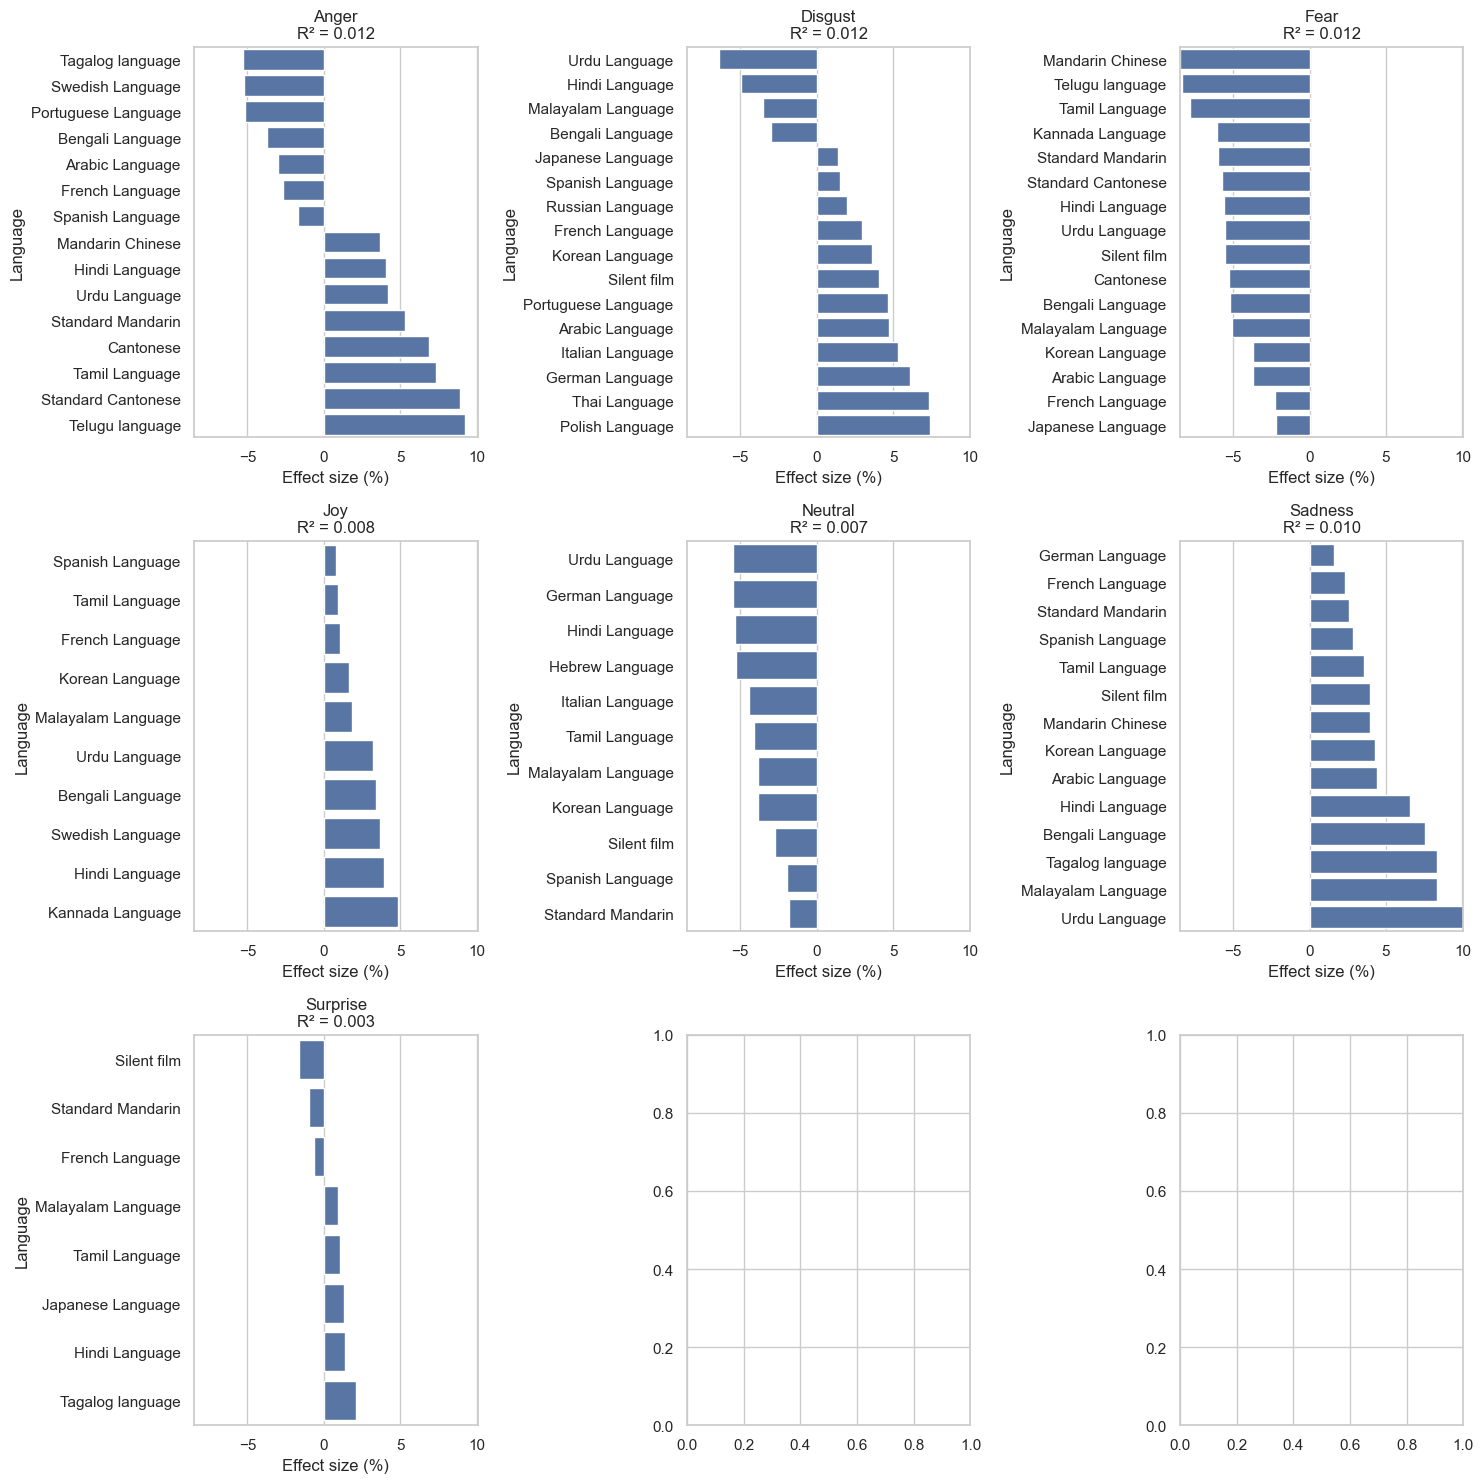

In [56]:
# Plot significant parameters for each emotion
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Find global min and max for consistent scale
all_params = []
for emotion in EMOTIONS:
    significant_params = regression_results[emotion]['significant_params']
    params_no_intercept = significant_params[1:]
    all_params.extend(params_no_intercept.values)
global_min, global_max = min(all_params), max(all_params)

for i, emotion in enumerate(EMOTIONS):
    if i < len(axes):
        significant_params = regression_results[emotion]['significant_params']
        
        # Don't include intercept
        params_no_intercept = significant_params[1:]  
        params_sorted = params_no_intercept.sort_values(ascending=True)

        y_labels = params_sorted.index.astype(str).str.extract(r'\[T\.(.*?)\]')[0]

        # Create bar plot
        sns.barplot(x=params_sorted.values, 
                   y=y_labels, 
                   ax=axes[i])
        
        axes[i].set_title(f'{emotion.capitalize()}\nR² = {regression_results[emotion]["r_squared"]:.3f}')
        axes[i].set_xlabel('Effect size (%)')
        axes[i].set_ylabel('Language')
        axes[i].set_xlim(global_min, global_max)  # consistent scale

plt.tight_layout()

#### Analysis of Regression Results
English was used as the reference category since it is both the normative and largest category.

##### Overall effect size of language on emotional content is extremely low:
- The R² values are quite low (0.003-0.012) indicating language explains only a very small portion of the variance in emotional content
- This of course makes sense because the emotional content of a movie is MUCH more influenced factors such as the plot, the acting, the cinematography, etc.

##### Some observed effects
In the fear emotion, all significant languages have a negative effect on fear compared to English.

Likewise, in the joy and sadness emotions, all significant languages have a positive effect compared to English.

##### Correlated emotions
OLS assumes that emotions from the same movie are treated as independent observations. However, this is probably not true because a more positive-film is more likely to have more positive emotions.

In [58]:
# Run MANOVA for a multivariate analysis of the emotions
manova_data = prepare_data_for_analysis(df_languages)
manova = MANOVA.from_formula('anger + disgust + fear + joy + sadness + surprise ~ Languages', data=manova_data)
print("\nMANOVA Results:")
print(manova.mv_test())
manova_results = manova.mv_test()

manova_results.summary()


MANOVA Results:
                    Multivariate linear model
                                                                  
------------------------------------------------------------------
         Intercept        Value  Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
            Wilks' lambda 0.8999 6.0000 34012.0000 630.2629 0.0000
           Pillai's trace 0.1001 6.0000 34012.0000 630.2629 0.0000
   Hotelling-Lawley trace 0.1112 6.0000 34012.0000 630.2629 0.0000
      Roy's greatest root 0.1112 6.0000 34012.0000 630.2629 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
       Languages        Value   Num DF     Den DF   F Value Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.9447 162.0000 199859.5822 12.0125 0.0000

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Multivariate linear model
==================================================================
                                                                  
------------------------------------------------------------------
         Intercept        Value  Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
            Wilks' lambda 0.8999 6.0000 34012.0000 630.2629 0.0000
           Pillai's trace 0.1001 6.0000 34012.0000 630.2629 0.0000
   Hotelling-Lawley trace 0.1112 6.0000 34012.0000 630.2629 0.0000
      Roy's greatest root 0.1112 6.0000 34012.0000 630.2629 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
       Languages        Value   Num DF     Den DF   F Value Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.9447 162.0000 199859.5822 12.0125 0.0000
         Pillai's trace 0.0563 162.0000 204102.0000 11.9396 0.0000
 Hotelling-Lawley trace 0.0576 162.0000 164024.1490 12.0840 0.0000
    Roy's greatest root 0.0326  27.0000  34017.0000 41.0179 0.0000
==================================================================

"""

#### MANOVA Results

All four test statistics (Wilks' lambda, Pillai's trace, Hotelling-Lawley trace, and Roy's greatest root) show highly significant results (Pr > F = 0.0000). This strongly indicates that there are significant differences in emotional expression patterns across different languages in movies.

However, as we might expect from our earlier analysis on the ANOVA for each emotion, the effect sizes are extremely small. With a Wilks' lambda of 0.9447, this means that that only 5.53% of the variance is explained by language.